----

<h1 style="text-align:center;">Telecom Prepaid Plan Revenue Analysis</h1>

## Objective

This project analyzes customer behavior and revenue generation for two prepaid telecom plans, Surf and Ultimate. The objective is to determine which plan generates higher revenue and to support advertising budget allocation with statistical evidence.

The analysis uses data from 500 customers during 2018, including demographic information, plan type, call minutes, text messages, internet usage, and monthly charges.

## Approach

In this project, the data from each CSV file is first examined to understand its structure and content. The datasets are loaded and inspected to verify the number  of rows and colums, confirm the data types are appropriate for each variable, identify missing values and determine how the handle them based on context, and detect duplicated records, either across entire rows or within specific columns when relevant.

After the data is prepared, and exploratory data analysis is conducted using bar charts, histograms, and boxplots, together with descriptive statistics such as the mean, variance, and standar deviation. Hypothesis test are then applied to assess whether differences in average revenue are statistically significant between plans and between users in the NY-NJ area and those in other regions. Finally, total revenue is calculated for each plan to determine wich tariff generates higher overall income.

## 1. Data preparation

In [1]:
import sys
sys.path.insert(0, "./_pkgs")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import re
from functools import reduce
from itables import show
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from ticks_configuration import setup_minor_ticks

In [3]:
df_megaline_calls = pd.read_csv('datasets/megaline_calls.csv', sep = ',')
df_megaline_internet = pd.read_csv('datasets/megaline_internet.csv', sep = ',')
df_megaline_messages = pd.read_csv('datasets/megaline_messages.csv', sep = ',')
df_megaline_plans = pd.read_csv('datasets/megaline_plans.csv', sep = ',')
df_megaline_users = pd.read_csv('datasets/megaline_users.csv', sep = ',')

The data is distributed across multiple tables: plans, users, calls, messages, and internet. Each datasets is inspected individually to gain an initial understanding of its structure and content. This includes reviewing the number of rows and columns, verifyng data types, identifying missing values, and checking for duplicated records. When necessary, corrections are applied to ensure the data is consistent and suitable for analysis.

In [4]:
df_megaline_plans.info()
display(df_megaline_plans)

<class 'pandas.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      str    
dtypes: float64(2), int64(5), str(1)
memory usage: 260.0 bytes


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


No missing values or duplicated records are present, and all columns have appropriate data types. The table contains two rows, and the information is consistent with prior details: the Surf plan includes 15,360 MB = 15 GB of internet, while the Ultimate plan includes 30,720 MB = 30 GB. To avoid extra charges, usage must not exceed the plan’s included limits for messages, data, and call minutes. Monthly data usage is rounded up to the next full gigabyte, and call duration is rounded up to the next full minute per call. Any usage beyond the included limits is billed according to the per-GB, per-message, and per-minute rates specified in the plan.


No corrections were required for the plans table. Numeric columns related to usage limits and pricing were validated to ensure consistent units and appropriate data types. Integer fields represent included allowances and monthly fees, while per-unit charges are stored as floating-point values. The plan_name column contains valid string values. No missing or duplicated records were found.

In [5]:
df_megaline_plans['gb_included'] = df_megaline_plans['mb_per_month_included']/1024

In [6]:
display(df_megaline_plans)

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_included
0,50,15360,500,20,10,0.03,0.03,surf,15.0
1,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0


A new column, gb_included, was added to simplify the calculation of user charges, since the data usage is billed per gigabyte rather than per MB.

In [7]:
df_megaline_users.info()
display(df_megaline_users.sample(5))

<class 'pandas.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   user_id     500 non-null    int64
 1   first_name  500 non-null    str  
 2   last_name   500 non-null    str  
 3   age         500 non-null    int64
 4   city        500 non-null    str  
 5   reg_date    500 non-null    str  
 6   plan        500 non-null    str  
 7   churn_date  34 non-null     str  
dtypes: int64(2), str(6)
memory usage: 31.4 KB


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
104,1104,Thurman,Stephens,20,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-12-23,ultimate,NaN
475,1475,Arlen,Sutton,66,"Dallas-Fort Worth-Arlington, TX MSA",2018-05-28,ultimate,NaN
43,1043,Carlos,Hinton,42,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-06-20,ultimate,NaN
476,1476,Tammara,Dorsey,24,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-06-10,ultimate,NaN
374,1374,Ching,Watts,55,"Louisville/Jefferson County, KY-IN MSA",2018-02-14,surf,NaN


In [8]:
display(df_megaline_users[~df_megaline_users['churn_date'].isna()])

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
6,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18
12,1012,Jonelle,Mcbride,59,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-06-28,surf,2018-11-16
22,1022,Bo,Snow,73,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-04-20,surf,2018-09-07
40,1040,Paris,Santos,72,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",2018-12-23,surf,2018-12-30
50,1050,Jone,Owen,23,"Miami-Fort Lauderdale-West Palm Beach, FL MSA",2018-03-20,ultimate,2018-10-07
54,1054,Denis,Frost,50,"Phoenix-Mesa-Chandler, AZ MSA",2018-04-21,surf,2018-12-31
67,1067,Robt,Allen,37,"Grand Rapids-Kentwood, MI MSA",2018-09-24,surf,2018-11-24
83,1083,Lyndia,Acevedo,65,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-10-26,surf,2018-12-18
84,1084,Wiley,Mckinney,21,"Miami-Fort Lauderdale-West Palm Beach, FL MSA",2018-06-04,surf,2018-11-11
94,1094,Walter,Petersen,54,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-10-30,surf,2018-12-12


In [9]:
print(df_megaline_users.columns)

Index(['user_id', 'first_name', 'last_name', 'age', 'city', 'reg_date', 'plan',
       'churn_date'],
      dtype='str')


All missing values in the churn_date column indicate that the service is still active.

The reg_date and churn_date columns are converted from object to datetime, and missing values in churn_date are kept as NaT since since I know that the NaT values represents that the user is stil using the service and they do not affect the statical analysis.

In [10]:
df_megaline_users['reg_date'] = pd.to_datetime(df_megaline_users['reg_date'], format = '%Y-%m-%d', errors = 'coerce')

In [11]:
df_megaline_users['churn_date'] = pd.to_datetime(df_megaline_users['churn_date'], format = '%Y-%m-%d', errors = 'coerce')

In [12]:
df_megaline_users.info()

<class 'pandas.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    str           
 2   last_name   500 non-null    str           
 3   age         500 non-null    int64         
 4   city        500 non-null    str           
 5   reg_date    500 non-null    datetime64[us]
 6   plan        500 non-null    str           
 7   churn_date  34 non-null     datetime64[us]
dtypes: datetime64[us](2), int64(2), str(4)
memory usage: 31.4 KB


In [13]:
display(df_megaline_users[~df_megaline_users['churn_date'].isna()].head())

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
6,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18
12,1012,Jonelle,Mcbride,59,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-06-28,surf,2018-11-16
22,1022,Bo,Snow,73,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-04-20,surf,2018-09-07
40,1040,Paris,Santos,72,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",2018-12-23,surf,2018-12-30
50,1050,Jone,Owen,23,"Miami-Fort Lauderdale-West Palm Beach, FL MSA",2018-03-20,ultimate,2018-10-07


In [14]:
display(df_megaline_users.sample(5))

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
70,1070,Jacelyn,Contreras,66,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-05-12,surf,NaT
282,1282,Annice,Calhoun,61,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-01,ultimate,NaT
37,1037,Reena,Velazquez,20,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-11,ultimate,NaT
224,1224,Kelly,Cole,74,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-06-28,ultimate,NaT
341,1341,Kaila,Andrews,28,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-06-17,surf,NaT


In [15]:
df_megaline_users['is_active'] = df_megaline_users['churn_date'].isna()

In [16]:
# First and last names are normalized to lowercase with no extra spaces.
df_megaline_users['first_name'] = df_megaline_users['first_name'].str.strip().str.lower()
df_megaline_users['last_name'] = df_megaline_users['last_name'].str.strip().str.lower()

In [17]:
# Cyti names are normalized
symbols_city_names = set(
    re.findall(r'[^a-zA-Z\s]', ''.join(df_megaline_users['city'].dropna()))
)
print(symbols_city_names)

{'.', ',', '/', '-', '–'}


In [18]:
df_megaline_users['city'] = (df_megaline_users['city'].str.strip().str.lower()
    .str.replace(r'[–-]', ' ', regex=True)
    .str.replace(r'[,/\.]', ' ', regex=True)
    .str.replace(r'\s+', ' ', regex=True))

In [19]:
df_megaline_users['city'] = df_megaline_users['city'].str.replace(' ', '_')

In [20]:
display(df_megaline_users.sample(5))

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,is_active
108,1108,porfirio,kane,45,salt_lake_city_ut_msa,2018-12-30,ultimate,NaT,True
413,1413,andre,hensley,38,bakersfield_ca_msa,2018-07-12,surf,NaT,True
350,1350,al,rasmussen,29,atlanta_sandy_springs_roswell_ga_msa,2018-03-09,surf,NaT,True
252,1252,mitsue,york,27,detroit_warren_dearborn_mi_msa,2018-06-10,surf,NaT,True
89,1089,malena,kelley,70,philadelphia_camden_wilmington_pa_nj_de_md_msa,2018-09-03,surf,NaT,True


In [21]:
print(df_megaline_users.duplicated().sum())
print(df_megaline_users.duplicated(subset = ['first_name','last_name']).any())
for col in df_megaline_users:
    print(col, df_megaline_users[col].duplicated().sum())

0
False
user_id 0
first_name 42
last_name 101
age 442
city 427
reg_date 234
plan 498
churn_date 470
is_active 498


First and last names are normalized to lowercase with no extra spaces, and city names are normalized by removing extra spaces, using underscores as separators, and removing non-alphanumeric symbols. No duplicated rows are found, and the user_id column contains no duplicated values.

In [22]:
# print a summary of the calls DataFrame
df_megaline_calls.info()

<class 'pandas.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  str    
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  str    
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), str(2)
memory usage: 4.2 MB


In [23]:
# Print a sample of the calls DataFrame
display(df_megaline_calls.sample(5))
print(df_megaline_calls.columns)

,id,user_id,call_date,duration
45830,1166_13,1166,2018-10-21,0.81
124576,1440_92,1440,2018-08-08,6.28
12465,1054_189,1054,2018-09-02,4.10
43940,1159_536,1159,2018-12-09,7.41
117440,1411_33,1411,2018-09-08,0.00


Index(['id', 'user_id', 'call_date', 'duration'], dtype='str')


The call_date column is of type object and it should be converted to datetime.

The call_date column is converted from object to datetime.

In [24]:
df_megaline_calls['call_date'] = pd.to_datetime(df_megaline_calls['call_date'], format = '%Y-%m-%d', errors = 'coerce')

In [25]:
df_megaline_calls.info()

<class 'pandas.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  str           
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[us]
 3   duration   137735 non-null  float64       
dtypes: datetime64[us](1), float64(1), int64(1), str(1)
memory usage: 4.2 MB


In [26]:
print(df_megaline_calls.duplicated().sum())
for col in df_megaline_calls:
    print(col, df_megaline_calls[col].duplicated().sum())

0
id 0
user_id 137254
call_date 137384
duration 134933


No duplicated rows are observed, and no duplicated values are present in the id column.

In [27]:
df_megaline_calls['call_month'] = df_megaline_calls['call_date'].dt.month

In [28]:
display(df_megaline_calls[df_megaline_calls['duration'] == 0])

,id,user_id,call_date,duration,call_month
19,1001_4,1001,2018-12-05,0.0,12
25,1001_13,1001,2018-12-24,0.0,12
31,1001_30,1001,2018-10-17,0.0,10
32,1001_31,1001,2018-11-03,0.0,11
34,1001_35,1001,2018-12-21,0.0,12
...,...,...,...,...,...
137714,1499_183,1499,2018-11-10,0.0,11
137715,1499_184,1499,2018-09-15,0.0,9
137720,1499_189,1499,2018-12-27,0.0,12
137722,1499_191,1499,2018-12-24,0.0,12


In [29]:
df_megaline_calls['duration_ceiled'] = np.ceil(df_megaline_calls['duration'])

Some calls have a duration of 0.0 seconds. Applying the ceil function leaves these values at zero. Since there is no rule stating that zero-second calls should be billed as one minute, they are kept as zero in this analysis. However, these calls are excluded from visualizations and analyses that rely on call duration, such as the number of calls per month.

A new column is created to store the month in which calls were made. In addition, the ceiling function is applied to the call duration to create a new column named duration_ceiled, since calls are billed by rounding up to the next minute even if only one additional second is used.

In [30]:
# Display a summary of the messages DataFrame
df_megaline_messages.info()
# Print a sample of the messages DataFrame
display(df_megaline_messages.sample(5))
print(df_megaline_messages.columns)


<class 'pandas.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   id            76051 non-null  str  
 1   user_id       76051 non-null  int64
 2   message_date  76051 non-null  str  
dtypes: int64(1), str(2)
memory usage: 1.7 MB


,id,user_id,message_date
34787,1222_0,1222,2018-12-05
18119,1119_819,1119,2018-11-08
1089,1011_52,1011,2018-11-13
31794,1196_280,1196,2018-06-06
58740,1373_158,1373,2018-11-07


Index(['id', 'user_id', 'message_date'], dtype='str')


There are no missing values. However, the message_date column is converted from object to datetime. In the next step, after extracting the month from the message send date, the minumum and maximum values will be checked.

In [31]:
df_megaline_messages['message_date'] = pd.to_datetime(df_megaline_messages['message_date'], format = '%Y-%m-%d', errors = 'coerce')

In [32]:
df_megaline_messages.info()

<class 'pandas.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  str           
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[us]
dtypes: datetime64[us](1), int64(1), str(1)
memory usage: 1.7 MB


In [33]:
print(df_megaline_messages.duplicated().sum())
for col in df_megaline_messages:
    print(col, df_megaline_messages[col].duplicated().sum())

0
id 0
user_id 75649
message_date 75700


The message_date column is converted from object to datetime, and no duplicated rows or duplicated values are observed in the id column.


In [34]:
df_megaline_messages['message_month'] = df_megaline_messages['message_date'].dt.month

In [35]:
print(df_megaline_messages['message_month'].min(), df_megaline_messages['message_month'].max())

1 12


A new column named message_month is added to store the month in which messages were sent. The minimum and maximum values in the messages month column are 1 and 12, which is consistent with the months of the year.

In [36]:
# Display a summary of the internet DataFrame
df_megaline_internet.info()
# Display a sample of the internet DataFrame
display(df_megaline_internet.sample(5))
print(df_megaline_internet.columns)

<class 'pandas.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  str    
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  str    
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), str(2)
memory usage: 3.2 MB


,id,user_id,session_date,mb_used
5033,1028_609,1028,2018-09-30,0.00
10672,1054_207,1054,2018-05-14,138.87
93053,1434_291,1434,2018-03-17,498.86
8955,1046_240,1046,2018-12-08,6.96
26323,1122_278,1122,2018-07-25,511.78


Index(['id', 'user_id', 'session_date', 'mb_used'], dtype='str')


There are no missing values. The session_date column is of type object and should be converted to datetime.

In [37]:
df_megaline_internet['session_date'] = pd.to_datetime(df_megaline_internet['session_date'], format = '%Y-%m-%d', errors = 'coerce')

In [38]:
df_megaline_internet.info()

<class 'pandas.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  str           
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[us]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[us](1), float64(1), int64(1), str(1)
memory usage: 3.2 MB


In [39]:
print(df_megaline_internet.duplicated().sum())
for col in df_megaline_internet:
    print(col, df_megaline_internet[col].duplicated().sum())

0
id 0
user_id 104336
session_date 104474
mb_used 47201


The session_date column is converted to datetime. No duplicated rows or duplicated values are present in the id column.

In [40]:
df_megaline_internet['session_month'] = df_megaline_internet['session_date'].dt.month

A new column named session_month is added to store the month in which the internet session occurred. The minimum and maximum values in the messages month column are 1 and 12, which is consistent with the months of the year.


In [41]:
# Display the general information about the plans DataFrame
df_megaline_plans.info()

<class 'pandas.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      str    
 8   gb_included            2 non-null      float64
dtypes: float64(3), int64(5), str(1)
memory usage: 276.0 bytes


In [42]:
df_megaline_plans.columns

Index(['messages_included', 'mb_per_month_included', 'minutes_included',
       'usd_monthly_pay', 'usd_per_gb', 'usd_per_message', 'usd_per_minute',
       'plan_name', 'gb_included'],
      dtype='str')

## 2. User-level usage aggregation

In the next cell code, only call with a duration greater than 0 minutes are counted when computing the number of calls per user per month.

In [43]:
# The number of calls made by each user per month is calculated and stored.

calls_per_user_per_month = (df_megaline_calls[df_megaline_calls['duration'] > 0].groupby(['user_id', 'call_month'])['id'].count().reset_index(name = 'num_calls')
                           .sort_values(by = ['user_id', 'call_month']))
display(calls_per_user_per_month.head(5))

,user_id,call_month,num_calls
0,1000,12,16
1,1001,8,22
2,1001,9,38
3,1001,10,47
4,1001,11,49


In [44]:
# The total number of minutes used by each user per month is calculated and stored.

minutes_per_user_per_month = (df_megaline_calls.groupby(['user_id', 'call_month'])['duration_ceiled'].sum().reset_index(name = 'num_minutes')
                           .sort_values(by = ['user_id', 'call_month']))
display(minutes_per_user_per_month.head(7))


,user_id,call_month,num_minutes
0,1000,12,124.0
1,1001,8,182.0
2,1001,9,315.0
3,1001,10,393.0
4,1001,11,426.0
5,1001,12,412.0
6,1002,10,59.0


In [45]:
# The number of messages sent by each user per month is calculated and stored.

num_messages_per_user_per_month = (df_megaline_messages.groupby(['user_id', 'message_month'])['id'].count()
                                   .reset_index(name = 'num_messages').sort_values(by = ['user_id', 'message_month']))
display(num_messages_per_user_per_month.head(7))

,user_id,message_month,num_messages
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36
5,1001,12,44
6,1002,10,15


In [46]:
# The volume of internet traffic used by each user per month is calculated and stored.
num_gigabytes_per_user_per_month = (df_megaline_internet.groupby(['user_id', 'session_month'])['mb_used'].sum()
                                   .reset_index(name = 'megabytes_used').sort_values(by = ['user_id', 'session_month']))
display(num_gigabytes_per_user_per_month.head(7))

,user_id,session_month,megabytes_used
0,1000,12,1901.47
1,1001,8,6919.15
2,1001,9,13314.82
3,1001,10,22330.49
4,1001,11,18504.30
5,1001,12,19369.18
6,1002,10,6552.01


In [47]:
num_gigabytes_per_user_per_month['gigabytes_used'] = np.ceil(num_gigabytes_per_user_per_month['megabytes_used']/1024).astype(int)
display(num_gigabytes_per_user_per_month.head(7))

,user_id,session_month,megabytes_used,gigabytes_used
0,1000,12,1901.47,2
1,1001,8,6919.15,7
2,1001,9,13314.82,14
3,1001,10,22330.49,22
4,1001,11,18504.30,19
5,1001,12,19369.18,19
6,1002,10,6552.01,7


A new column named gigabytes_used is added to store the monthly internet usage, rounded up to the next gigabyte when usage exceeds multiples of 1024 MB.

In [48]:
#Here we rename all the columns so they have the same name on month
calls_per_user_per_month = calls_per_user_per_month.rename(columns = {'call_month' : 'month'})
minutes_per_user_per_month = minutes_per_user_per_month.rename(columns = {'call_month' : 'month'})
num_messages_per_user_per_month = num_messages_per_user_per_month.rename(columns = {'message_month' : 'month'})
num_gigabytes_per_user_per_month = num_gigabytes_per_user_per_month.rename(columns = {'session_month' : 'month'})

In [49]:
# The data on calls, minutes, messages, and internet usage are merged based on user_id and month.

dfs = [calls_per_user_per_month, minutes_per_user_per_month, num_messages_per_user_per_month, num_gigabytes_per_user_per_month]

df_usage = reduce(
    lambda left, right: left.merge(right, on=['user_id', 'month'], how='outer'),
    dfs
)

In [50]:
df_usage.info()
print(calls_per_user_per_month.shape)
print(minutes_per_user_per_month.shape)
print(num_messages_per_user_per_month.shape)
print(num_gigabytes_per_user_per_month.shape)

<class 'pandas.DataFrame'>
RangeIndex: 2293 entries, 0 to 2292
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         2293 non-null   int64  
 1   month           2293 non-null   int32  
 2   num_calls       2256 non-null   float64
 3   num_minutes     2258 non-null   float64
 4   num_messages    1806 non-null   float64
 5   megabytes_used  2277 non-null   float64
 6   gigabytes_used  2277 non-null   float64
dtypes: float64(5), int32(1), int64(1)
memory usage: 116.6 KB
(2256, 3)
(2258, 3)
(1806, 3)
(2277, 4)


In [51]:
display(df_usage.tail(5))

,user_id,month,num_calls,num_minutes,num_messages,megabytes_used,gigabytes_used
2288,1498,12,32.0,339.0,NaN,23137.69,23.0
2289,1499,9,35.0,346.0,NaN,12984.76,13.0
2290,1499,10,41.0,385.0,NaN,19492.43,20.0
2291,1499,11,39.0,308.0,NaN,16813.83,17.0
2292,1499,12,56.0,496.0,NaN,22059.21,22.0


In [52]:
display(df_usage)

,user_id,month,num_calls,num_minutes,num_messages,megabytes_used,gigabytes_used
0,1000,12,16.0,124.0,11.0,1901.47,2.0
1,1001,8,22.0,182.0,30.0,6919.15,7.0
2,1001,9,38.0,315.0,44.0,13314.82,14.0
3,1001,10,47.0,393.0,53.0,22330.49,22.0
4,1001,11,49.0,426.0,36.0,18504.30,19.0
...,...,...,...,...,...,...,...
2288,1498,12,32.0,339.0,NaN,23137.69,23.0
2289,1499,9,35.0,346.0,NaN,12984.76,13.0
2290,1499,10,41.0,385.0,NaN,19492.43,20.0
2291,1499,11,39.0,308.0,NaN,16813.83,17.0


In [53]:
print(df_usage.duplicated(subset = ['user_id', 'month']).any())

False


## 3. Monthly revenue per user

Monthly revenue per user is calculated using the information from the plans DataFrame, which specifies the services included in each plan and the additional charges applied when usage exceeds plan limits.

In [54]:
cols = ['num_calls', 'num_minutes', 'num_messages', 'megabytes_used', 'gigabytes_used']

df_usage[cols] = df_usage[cols].fillna(0)

In [55]:
print(df_usage.isna().sum())

user_id           0
month             0
num_calls         0
num_minutes       0
num_messages      0
megabytes_used    0
gigabytes_used    0
dtype: int64


In [56]:
df_usage = df_usage.merge(
    df_megaline_users[['user_id', 'plan']], on = 'user_id', how = 'left'
)

In [57]:
display(df_usage)

,user_id,month,num_calls,num_minutes,num_messages,megabytes_used,gigabytes_used,plan
0,1000,12,16.0,124.0,11.0,1901.47,2.0,ultimate
1,1001,8,22.0,182.0,30.0,6919.15,7.0,surf
2,1001,9,38.0,315.0,44.0,13314.82,14.0,surf
3,1001,10,47.0,393.0,53.0,22330.49,22.0,surf
4,1001,11,49.0,426.0,36.0,18504.30,19.0,surf
...,...,...,...,...,...,...,...,...
2288,1498,12,32.0,339.0,0.0,23137.69,23.0,surf
2289,1499,9,35.0,346.0,0.0,12984.76,13.0,surf
2290,1499,10,41.0,385.0,0.0,19492.43,20.0,surf
2291,1499,11,39.0,308.0,0.0,16813.83,17.0,surf


In [58]:
surf = df_megaline_plans.loc[df_megaline_plans['plan_name'] == 'surf'].iloc[0]
ult  = df_megaline_plans.loc[df_megaline_plans['plan_name'] == 'ultimate'].iloc[0]
print(surf)
print(ult)

messages_included           50
mb_per_month_included    15360
minutes_included           500
usd_monthly_pay             20
usd_per_gb                  10
usd_per_message           0.03
usd_per_minute            0.03
plan_name                 surf
gb_included               15.0
Name: 0, dtype: object
messages_included            1000
mb_per_month_included       30720
minutes_included             3000
usd_monthly_pay                70
usd_per_gb                      7
usd_per_message              0.01
usd_per_minute               0.01
plan_name                ultimate
gb_included                  30.0
Name: 1, dtype: object


In [59]:
# extract plan parameters as scalars (one row per plan)
surf = df_megaline_plans.loc[df_megaline_plans['plan_name'] == 'surf'].iloc[0]
ult  = df_megaline_plans.loc[df_megaline_plans['plan_name'] == 'ultimate'].iloc[0]

# initialize the total_charge column to 0
df_usage['total_charge'] = 0.0

# create boolean masks by plan
m_surf = df_usage['plan'] == 'surf'
m_ult  = df_usage['plan'] == 'ultimate'

# compute charges for surf (vectorized)
gb_included_surf = surf['mb_per_month_included'] / 1024

extra_messages_surf = (df_usage.loc[m_surf, 'num_messages'] - surf['messages_included']).clip(lower=0)
extra_minutes_surf  = (df_usage.loc[m_surf, 'num_minutes']  - surf['minutes_included']).clip(lower=0)
extra_gb_surf       = (df_usage.loc[m_surf, 'gigabytes_used'] - gb_included_surf).clip(lower=0)

df_usage.loc[m_surf, 'total_charge'] = (
    surf['usd_monthly_pay']
    + extra_messages_surf * surf['usd_per_message']
    + extra_minutes_surf  * surf['usd_per_minute']
    + extra_gb_surf       * surf['usd_per_gb']
)

# compute charges for Ultimate (vectorized)
gb_included_ult = ult['mb_per_month_included'] / 1024

extra_messages_ult = (df_usage.loc[m_ult, 'num_messages'] - ult['messages_included']).clip(lower=0)
extra_minutes_ult  = (df_usage.loc[m_ult, 'num_minutes']  - ult['minutes_included']).clip(lower=0)
extra_gb_ult       = (df_usage.loc[m_ult, 'gigabytes_used'] - gb_included_ult).clip(lower=0)

df_usage.loc[m_ult, 'total_charge'] = (
    ult['usd_monthly_pay']
    + extra_messages_ult * ult['usd_per_message']
    + extra_minutes_ult  * ult['usd_per_minute']
    + extra_gb_ult       * ult['usd_per_gb']
)

In [60]:
display(df_usage)

,user_id,month,num_calls,num_minutes,num_messages,megabytes_used,gigabytes_used,plan,total_charge
0,1000,12,16.0,124.0,11.0,1901.47,2.0,ultimate,70.00
1,1001,8,22.0,182.0,30.0,6919.15,7.0,surf,20.00
2,1001,9,38.0,315.0,44.0,13314.82,14.0,surf,20.00
3,1001,10,47.0,393.0,53.0,22330.49,22.0,surf,90.09
4,1001,11,49.0,426.0,36.0,18504.30,19.0,surf,60.00
...,...,...,...,...,...,...,...,...,...
2288,1498,12,32.0,339.0,0.0,23137.69,23.0,surf,100.00
2289,1499,9,35.0,346.0,0.0,12984.76,13.0,surf,20.00
2290,1499,10,41.0,385.0,0.0,19492.43,20.0,surf,70.00
2291,1499,11,39.0,308.0,0.0,16813.83,17.0,surf,40.00


In [61]:
display(df_usage[((df_usage['num_minutes'] > 3000) | (df_usage['num_messages'] > 1000) | (df_usage['gigabytes_used'] > 30)) & (df_usage['plan'] == 'ultimate' )])

,user_id,month,num_calls,num_minutes,num_messages,megabytes_used,gigabytes_used,plan,total_charge
20,1006,12,7.0,59.0,139.0,32118.82,32.0,ultimate,84.0
95,1028,3,4.0,39.0,66.0,36061.04,36.0,ultimate,112.0
96,1028,4,6.0,53.0,77.0,37761.59,37.0,ultimate,119.0
97,1028,5,7.0,67.0,84.0,32907.83,33.0,ultimate,91.0
98,1028,6,9.0,49.0,66.0,37907.14,38.0,ultimate,126.0
99,1028,7,6.0,53.0,85.0,38826.70,38.0,ultimate,126.0
100,1028,8,7.0,76.0,74.0,40388.21,40.0,ultimate,140.0
102,1028,10,6.0,39.0,73.0,46595.33,46.0,ultimate,182.0
103,1028,11,8.0,69.0,77.0,42952.59,42.0,ultimate,154.0
104,1028,12,6.0,43.0,74.0,37603.26,37.0,ultimate,119.0


## 4. User behavior analysis

In [62]:
print(df_usage['num_calls'].mean())

48.365023986044484


In [63]:
# The average call duration is compared by plan and by month, and a bar chart is used to visualize the results.
mean_of_num_minutes_per_plan = df_usage.groupby(['plan', 'month'])['num_minutes'].mean().reset_index(name = 'avg_minutes_per_month_by_plan')
print(mean_of_num_minutes_per_plan)

        plan  month  avg_minutes_per_month_by_plan
0       surf      1                     203.000000
1       surf      2                     297.000000
2       surf      3                     330.000000
3       surf      4                     351.540000
4       surf      5                     399.584416
5       surf      6                     431.298969
6       surf      7                     449.983471
7       surf      8                     410.111111
8       surf      9                     414.226804
9       surf     10                     429.729958
10      surf     11                     423.325088
11      surf     12                     473.836478
12  ultimate      1                     193.500000
13  ultimate      2                     403.142857
14  ultimate      3                     304.250000
15  ultimate      4                     336.857143
16  ultimate      5                     406.241379
17  ultimate      6                     370.957447
18  ultimate      7            

In [64]:
surf_minutes_avg = mean_of_num_minutes_per_plan[mean_of_num_minutes_per_plan['plan'] == 'surf']
ultimate_minutes_avg = mean_of_num_minutes_per_plan[mean_of_num_minutes_per_plan['plan'] == 'ultimate']

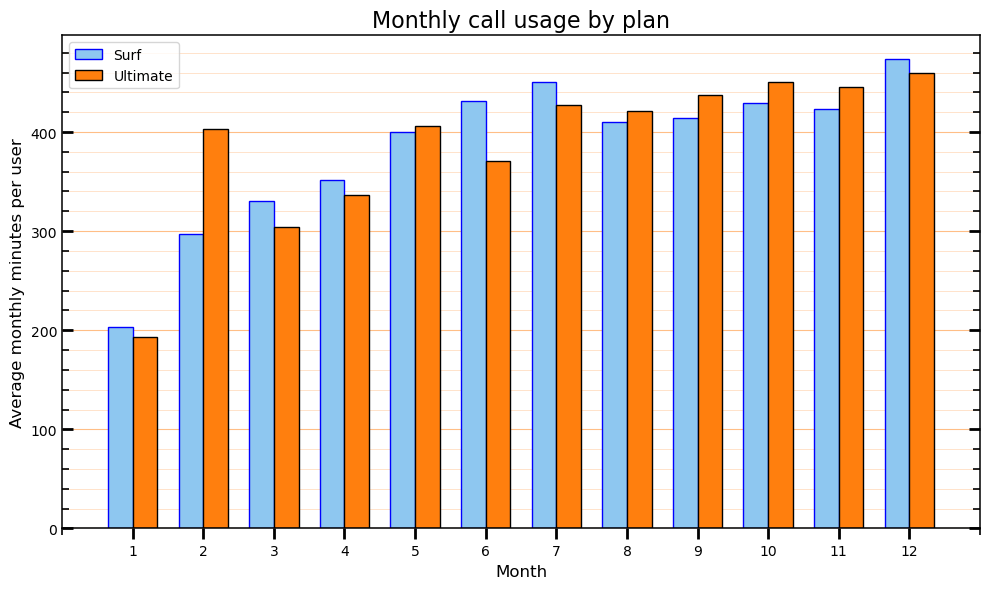

In [65]:
x = np.arange(len(surf_minutes_avg['month']))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(
    x - width/2,
    surf_minutes_avg['avg_minutes_per_month_by_plan'].values,
    width=width,
    edgecolor='blue',
    linewidth=1.0,
    color='#8EC7F0',
    alpha=1,
    label='Surf'
)

ax.bar(
    x + width/2,
    ultimate_minutes_avg['avg_minutes_per_month_by_plan'].values,
    width=width,
    edgecolor='black',
    linewidth=1.0,
    color='#FF7F0E',
    alpha=1,
    label='Ultimate'
)

ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Average monthly minutes per user', fontsize=12)
ax.set_title('Monthly call usage by plan', fontsize=16)

ax.set_xticks(x)
ax.set_xticklabels(surf_minutes_avg['month'], rotation=0)

for side in ['top', 'right', 'bottom', 'left']:
    ax.spines[side].set_linewidth(1.1)

ax.tick_params(labelsize=10)

ax.set_axisbelow(True)

ax.grid(axis='y', which='major', linewidth=0.8, alpha=0.5, color="#FF7F0E")
ax.grid(axis='y', which='minor', linewidth=0.5, alpha=0.3, color='#FF7F0E')

ax.yaxis.set_minor_locator(AutoMinorLocator(2))

setup_minor_ticks(
    ax,
    x_minor_divisions=1,
    y_minor_divisions=5,
    major=(8, 2),
    minor=(5, 1.2),
    sides=dict(top=False, right=True, bottom=True, left=True),
    direction_top='in',
    direction_bottom='out',
    direction_left='in',
    direction_right='in'
)

ax.set_xlim(-1, len(x))

ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

Monthly averages of call minutes per user were calculated separately for the Surf and Ultimate plans. Average usage increases across months for both plans. During the last fourth months, the Ultimate plan shows slightly higher average values than Surf.

In [66]:
# The number of monthly minutes used by users is compared between plans.
total_of_num_minutes_per_plan_per_month = df_usage.groupby(['plan', 'month', 'user_id'])['num_minutes'].sum().reset_index(name = 'total_minutes_per_user_per_month_by_plan')
display(total_of_num_minutes_per_plan_per_month.sort_values(by = 'user_id'))

,plan,month,user_id,total_minutes_per_user_per_month_by_plan
2142,ultimate,12,1000,124.0
1255,surf,12,1001,412.0
541,surf,9,1001,315.0
972,surf,11,1001,426.0
735,surf,10,1001,393.0
...,...,...,...,...
160,surf,5,1498,288.0
971,surf,10,1499,385.0
1254,surf,11,1499,308.0
1572,surf,12,1499,496.0


In [67]:
surf_total_min = total_of_num_minutes_per_plan_per_month[total_of_num_minutes_per_plan_per_month['plan'] == 'surf']
ultimate_total_min = total_of_num_minutes_per_plan_per_month[total_of_num_minutes_per_plan_per_month['plan'] == 'ultimate']

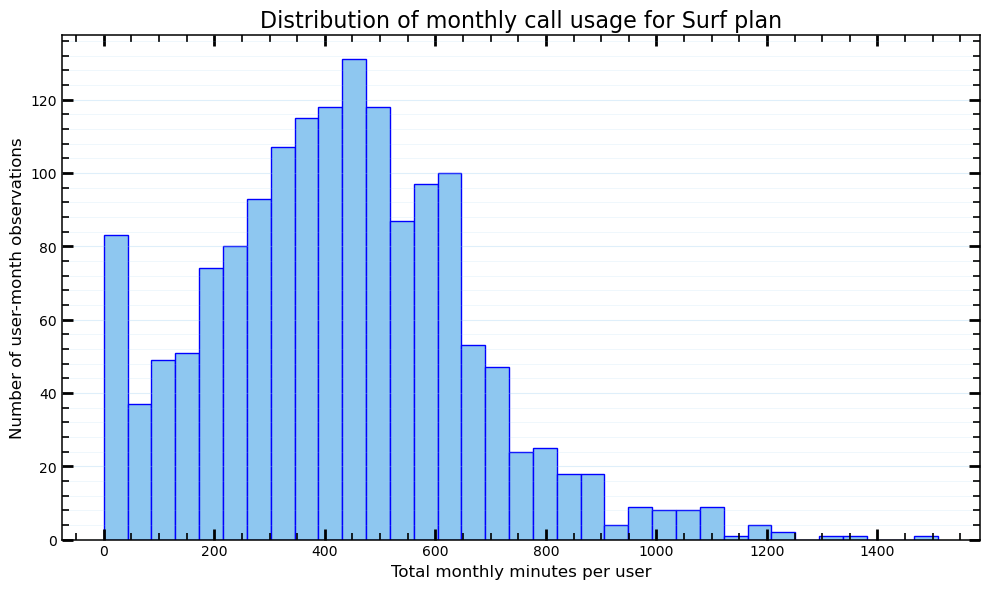

In [68]:
x = surf_total_min['total_minutes_per_user_per_month_by_plan']

fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(
    x,
    bins=35,
    edgecolor='blue',
    linewidth=1.0,
    color='#8EC7F0',
    alpha=1
)

ax.set_xlabel('Total monthly minutes per user', fontsize=12)
ax.set_ylabel('Number of user-month observations', fontsize=12)
ax.set_title('Distribution of monthly call usage for Surf plan', fontsize=16)

for side in ['top', 'right', 'bottom', 'left']:
    ax.spines[side].set_linewidth(1.1)

ax.tick_params(labelsize=10)

ax.set_axisbelow(False)

# Grid styling consistent with your bar charts
ax.grid(axis='y', which='major', linewidth=0.8, alpha=0.28, color="#8EC7F0")
ax.grid(axis='y', which='minor', linewidth=0.5, alpha=0.2, color='#8EC7F0')

ax.yaxis.set_minor_locator(AutoMinorLocator(2))

setup_minor_ticks(
    ax,
    x_minor_divisions=4,
    y_minor_divisions=5,
    major=(8, 2),
    minor=(5, 1.2),
    sides=dict(top=True, right=True, bottom=True, left=True),
    direction_top='in',
    direction_bottom='in',
    direction_left='in',
    direction_right='in'
)

plt.tight_layout()
plt.show()

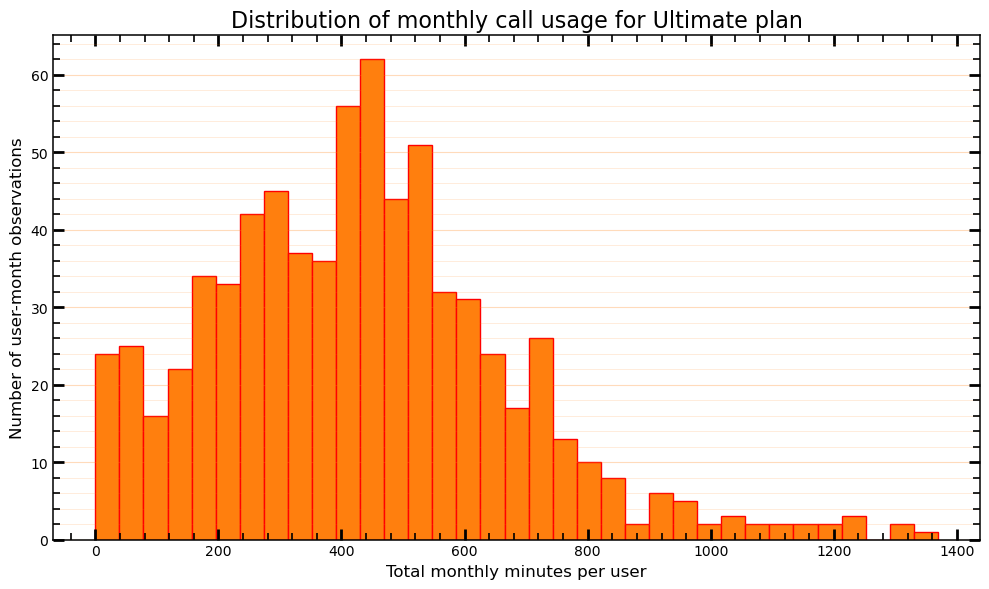

In [69]:
x = ultimate_total_min['total_minutes_per_user_per_month_by_plan']

fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(
    x,
    bins=35,
    edgecolor='red',
    linewidth=1.0,
    color='#FF7F0E',
    alpha=1
)

ax.set_xlabel('Total monthly minutes per user', fontsize=12)
ax.set_ylabel('Number of user-month observations', fontsize=12)
ax.set_title('Distribution of monthly call usage for Ultimate plan', fontsize=16)

for side in ['top', 'right', 'bottom', 'left']:
    ax.spines[side].set_linewidth(1.1)

ax.tick_params(labelsize=10)

# Keep grid above bars as you specified
ax.set_axisbelow(False)

# Grid styling consistent with your histogram adjustment
ax.grid(axis='y', which='major', linewidth=0.8, alpha=0.28, color="#FF7F0E")
ax.grid(axis='y', which='minor', linewidth=0.5, alpha=0.2, color='#FF7F0E')

ax.yaxis.set_minor_locator(AutoMinorLocator(2))

setup_minor_ticks(
    ax,
    x_minor_divisions=5,
    y_minor_divisions=5,
    major=(8, 2),
    minor=(5, 1.2),
    sides=dict(top=True, right=True, bottom=True, left=True),
    direction_top='in',
    direction_bottom='in',
    direction_left='in',
    direction_right='in'
)

plt.tight_layout()
plt.show()

In [70]:
# Calculate the mean and variance of monthly call duration.

surf_total_min_mean = surf_total_min['total_minutes_per_user_per_month_by_plan'].mean()
surf_total_min_var = surf_total_min['total_minutes_per_user_per_month_by_plan'].var()
print('Mean monthly call duration (Surf):', surf_total_min_mean)
print('Variance of monthly call duration (Surf):', surf_total_min_var)

Mean monthly call duration (Surf): 428.7495232040687
Variance of monthly call duration (Surf): 54968.279460650374


In [71]:
ultimate_total_min_mean = ultimate_total_min['total_minutes_per_user_per_month_by_plan'].mean()
ultimate_total_min_var = ultimate_total_min['total_minutes_per_user_per_month_by_plan'].var()
print('Mean monthly call duration (Ultimate):', ultimate_total_min_mean)
print('Variance of monthly call duration (Ultimate):', ultimate_total_min_var)

Mean monthly call duration (Ultimate): 430.45
Variance of monthly call duration (Ultimate): 57844.46481223922


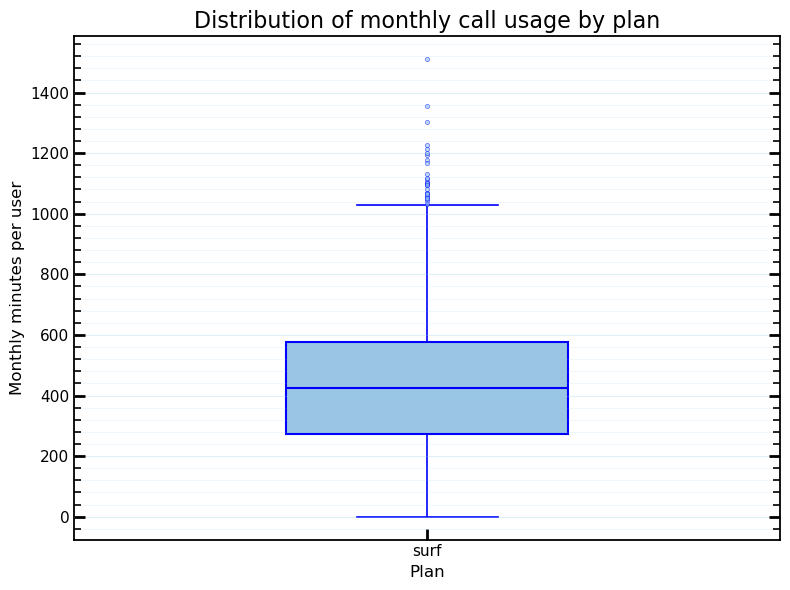

In [72]:
# Plot a boxplot to visualize the distribution of monthly call durations.
fig, ax = plt.subplots(figsize=(8, 6))

sns.boxplot(
    data=surf_total_min,
    x='plan',
    y='total_minutes_per_user_per_month_by_plan',
    ax=ax,
    width=0.4,
    color='#8EC7F0',
    linewidth=1.5,
    showfliers=True,
    boxprops=dict(edgecolor='blue'),
    whiskerprops=dict(color='blue', linewidth=1.2),
    capprops=dict(color='blue', linewidth=1.2),
    medianprops=dict(color='blue', linewidth=1.5),
    flierprops=dict(
        marker='o',
        markerfacecolor='#8EC7F0',
        markeredgecolor='blue',
        markersize=3,
        alpha=0.6,
        markeredgewidth=0.5
    )
)

ax.set_xlabel('Plan', fontsize=12)
ax.set_ylabel('Monthly minutes per user', fontsize=12)
ax.set_title('Distribution of monthly call usage by plan', fontsize=16)

for side in ['top', 'right', 'bottom', 'left']:
    ax.spines[side].set_linewidth(1.3)

ax.tick_params(labelsize=11)

ax.set_axisbelow(False)

ax.yaxis.set_minor_locator(AutoMinorLocator(2))

ax.grid(axis='y', which='major', linewidth=0.8, alpha=0.28, color='#8EC7F0')
ax.grid(axis='y', which='minor', linewidth=0.5, alpha=0.20, color='#8EC7F0')

setup_minor_ticks(
    ax,
    x_minor_divisions=1,
    y_minor_divisions=5,
    major=(8, 2),
    minor=(5, 1.2),
    sides=dict(top=False, right=True, bottom=True, left=True),
    direction_top='in',
    direction_bottom='in',
    direction_left='in',
    direction_right='in'
)

plt.tight_layout()
plt.show()

In [73]:
print(ultimate_total_min['total_minutes_per_user_per_month_by_plan'].quantile(0.25)-1.5*(ultimate_total_min['total_minutes_per_user_per_month_by_plan'].quantile(0.75)-ultimate_total_min['total_minutes_per_user_per_month_by_plan'].quantile(0.25)))

-197.875


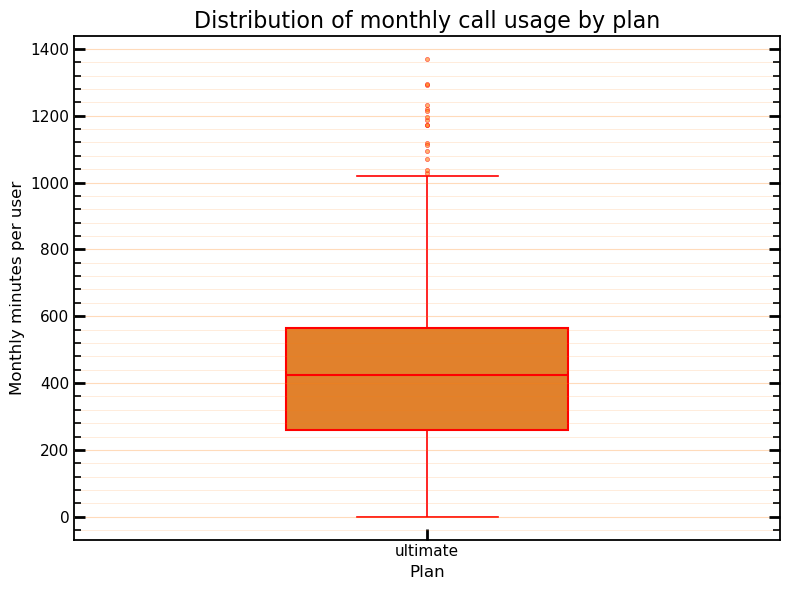

In [74]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.boxplot(
    data=ultimate_total_min,
    x='plan',
    y='total_minutes_per_user_per_month_by_plan',
    ax=ax,
    width=0.4,
    color='#FF7F0E',
    linewidth=1.5,
    showfliers=True,
    boxprops=dict(edgecolor='red'),
    whiskerprops=dict(color='red', linewidth=1.2),
    capprops=dict(color='red', linewidth=1.2),
    medianprops=dict(color='red', linewidth=1.5),
    flierprops=dict(
        marker='o',
        markerfacecolor='#FF7F0E',
        markeredgecolor='red',
        markersize=3,
        alpha=0.6,
        markeredgewidth=0.5
    )
)

ax.set_xlabel('Plan', fontsize=12)
ax.set_ylabel('Monthly minutes per user', fontsize=12)
ax.set_title('Distribution of monthly call usage by plan', fontsize=16)

for side in ['top', 'right', 'bottom', 'left']:
    ax.spines[side].set_linewidth(1.3)

ax.tick_params(labelsize=11)

ax.set_axisbelow(False)

ax.yaxis.set_minor_locator(AutoMinorLocator(2))

ax.grid(axis='y', which='major', linewidth=0.8, alpha=0.28, color='#FF7F0E')
ax.grid(axis='y', which='minor', linewidth=0.5, alpha=0.20, color='#FF7F0E')

setup_minor_ticks(
    ax,
    x_minor_divisions=1,
    y_minor_divisions=5,
    major=(8, 2),
    minor=(5, 1.2),
    sides=dict(top=False, right=True, bottom=True, left=True),
    direction_top='in',
    direction_bottom='in',
    direction_left='in',
    direction_right='in'
)

plt.tight_layout()
plt.show()

Monthly call usage per user was analyzed using histograms, summary statistics, and boxplots. For both plans, the distributions of monthly call usage are right-skewed. Most user-month observations fall roughly between 200 and 600 minutes, while a smaller number of observations exceed 800 minutes and extend up to approximately 1,400 to 1,500 minutes. These high-usage observations increase the mean relative to the bulk of the data. The mean monthly usage equals 428.75 minutes for the Surf plan and 430.45 minutes for the Ultimate plan, with corresponding variances of 54,968 and 57,844, respectively. The boxplots show comparable medians and interquartile ranges for both plans, with a limited number of high-usage observations appearing above the upper quartile.

In [75]:
# Compare the number of messages users tend to send each month for each plan
mean_of_num_messages_per_plan = df_usage.groupby(['plan', 'month'])['num_messages'].mean().reset_index(name = 'avg_messages_per_month_by_plan')
print(mean_of_num_messages_per_plan)

        plan  month  avg_messages_per_month_by_plan
0       surf      1                       10.500000
1       surf      2                       12.000000
2       surf      3                       15.260870
3       surf      4                       17.400000
4       surf      5                       24.012987
5       surf      6                       25.298969
6       surf      7                       27.033058
7       surf      8                       28.777778
8       surf      9                       30.762887
9       surf     10                       33.839662
10      surf     11                       32.385159
11      surf     12                       38.600629
12  ultimate      1                       15.500000
13  ultimate      2                       21.571429
14  ultimate      3                       20.250000
15  ultimate      4                       22.047619
16  ultimate      5                       32.103448
17  ultimate      6                       29.340426
18  ultimate

In [76]:
surf_messages_avg = mean_of_num_messages_per_plan[mean_of_num_messages_per_plan['plan'] == 'surf']
ultimate_messages_avg = mean_of_num_messages_per_plan[mean_of_num_messages_per_plan['plan'] == 'ultimate']

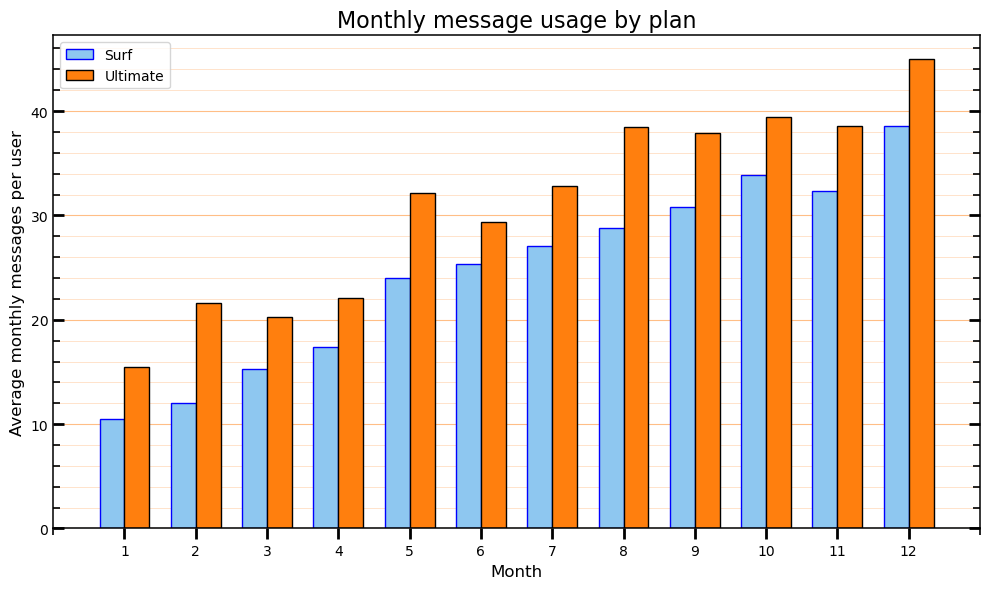

In [77]:
x = np.arange(len(surf_messages_avg['month']))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(
    x - width/2,
    surf_messages_avg['avg_messages_per_month_by_plan'].values,
    width=width,
    edgecolor='blue',
    linewidth=1.0,
    color='#8EC7F0',
    alpha=1,
    label='Surf'
)

ax.bar(
    x + width/2,
    ultimate_messages_avg['avg_messages_per_month_by_plan'].values,
    width=width,
    edgecolor='black',
    linewidth=1.0,
    color='#FF7F0E',
    alpha=1,
    label='Ultimate'
)

ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Average monthly messages per user', fontsize=12)
ax.set_title('Monthly message usage by plan', fontsize=16)

ax.set_xticks(x)
ax.set_xticklabels(surf_messages_avg['month'], rotation=0)

for side in ['top', 'right', 'bottom', 'left']:
    ax.spines[side].set_linewidth(1.1)

ax.tick_params(labelsize=10)

ax.set_axisbelow(True)

ax.grid(axis='y', which='major', linewidth=0.8, alpha=0.5, color="#FF7F0E")
ax.grid(axis='y', which='minor', linewidth=0.5, alpha=0.3, color='#FF7F0E')

ax.yaxis.set_minor_locator(AutoMinorLocator(2))

setup_minor_ticks(
    ax,
    x_minor_divisions=1,
    y_minor_divisions=5,
    major=(8, 2),
    minor=(5, 1.2),
    sides=dict(top=False, right=True, bottom=True, left=True),
    direction_top='in',
    direction_bottom='out',
    direction_left='in',
    direction_right='in'
)

ax.set_xlim(-1, len(x))

ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

Monthly average message usage per user was calculated by plan and by month. For both plans, the average number of messages sent per user increases over the course of the year. Surf users send and average of 11 messages in January and 39 messages in the December, while Ultimate users increase from 16 to 45 over the year. In every month, the Ultimate plan shows higher average message usage than the Surf plan, although the size of the difference varies across months. 

In [78]:
# The number of monthly message used by users is compared between plans.
total_of_num_messages_per_plan_per_month = df_usage.groupby(['plan', 'month', 'user_id'])['num_messages'].sum().reset_index(name = 'total_messages_per_user_per_month_by_plan')
display(total_of_num_messages_per_plan_per_month.sort_values(by = 'user_id'))

,plan,month,user_id,total_messages_per_user_per_month_by_plan
2142,ultimate,12,1000,11.0
1255,surf,12,1001,44.0
541,surf,9,1001,44.0
972,surf,11,1001,36.0
735,surf,10,1001,53.0
...,...,...,...,...
160,surf,5,1498,0.0
971,surf,10,1499,0.0
1254,surf,11,1499,0.0
1572,surf,12,1499,0.0


In [79]:
surf_total_mess = total_of_num_messages_per_plan_per_month[total_of_num_messages_per_plan_per_month['plan'] == 'surf']
ultimate_total_mess = total_of_num_messages_per_plan_per_month[total_of_num_messages_per_plan_per_month['plan'] == 'ultimate']

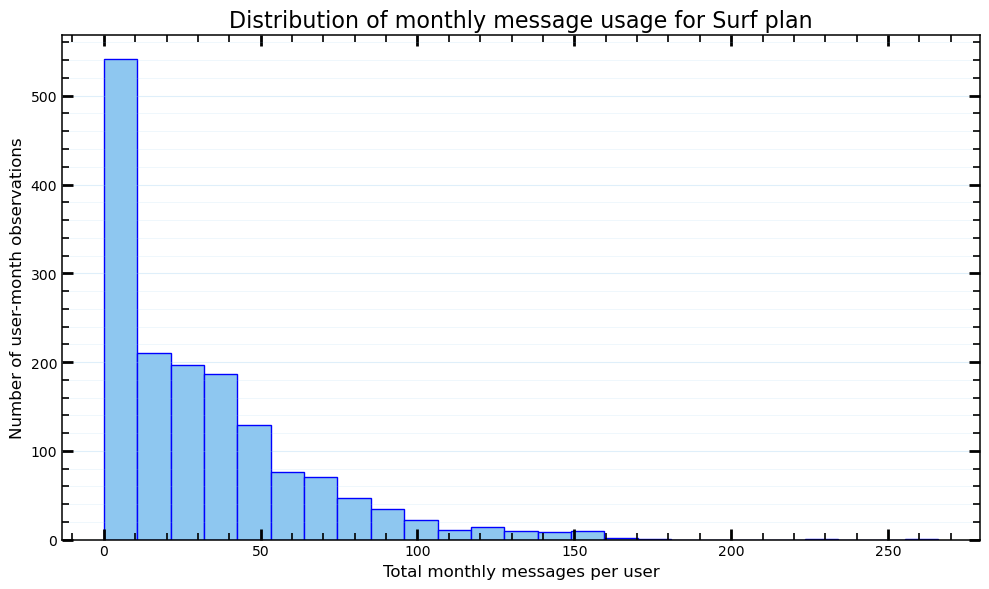

In [80]:
x = surf_total_mess['total_messages_per_user_per_month_by_plan']

fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(
    x,
    bins=25,
    edgecolor='blue',
    linewidth=1.0,
    color='#8EC7F0',
    alpha=1
)

ax.set_xlabel('Total monthly messages per user', fontsize=12)
ax.set_ylabel('Number of user-month observations', fontsize=12)
ax.set_title('Distribution of monthly message usage for Surf plan', fontsize=16)

for side in ['top', 'right', 'bottom', 'left']:
    ax.spines[side].set_linewidth(1.1)

ax.tick_params(labelsize=10)

# Grid above bars as per your chosen histogram style
ax.set_axisbelow(False)

ax.grid(axis='y', which='major', linewidth=0.8, alpha=0.28, color="#8EC7F0")
ax.grid(axis='y', which='minor', linewidth=0.5, alpha=0.2, color='#8EC7F0')

ax.yaxis.set_minor_locator(AutoMinorLocator(2))

setup_minor_ticks(
    ax,
    x_minor_divisions=5,
    y_minor_divisions=5,
    major=(8, 2),
    minor=(5, 1.2),
    sides=dict(top=True, right=True, bottom=True, left=True),
    direction_top='in',
    direction_bottom='in',
    direction_left='in',
    direction_right='in'
)

plt.tight_layout()
plt.show()

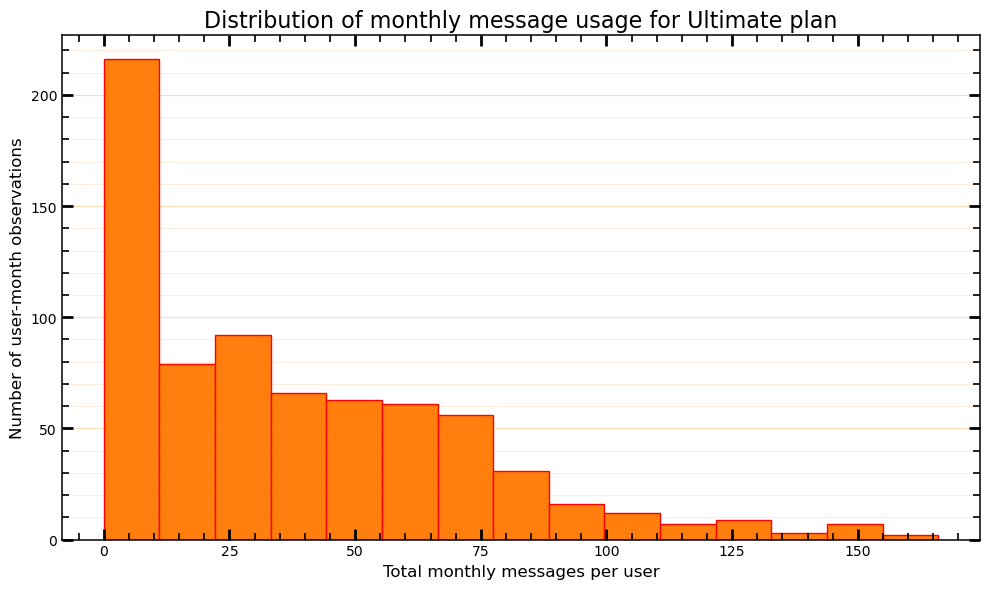

In [81]:
x = ultimate_total_mess['total_messages_per_user_per_month_by_plan']

fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(
    x,
    bins=15,
    edgecolor='red',
    linewidth=1.0,
    color='#FF7F0E',
    alpha=1
)

ax.set_xlabel('Total monthly messages per user', fontsize=12)
ax.set_ylabel('Number of user-month observations', fontsize=12)
ax.set_title('Distribution of monthly message usage for Ultimate plan', fontsize=16)

for side in ['top', 'right', 'bottom', 'left']:
    ax.spines[side].set_linewidth(1.1)

ax.tick_params(labelsize=10)

ax.set_axisbelow(False)

ax.grid(axis='y', which='major', linewidth=0.8, alpha=0.28, color="#FF7F0E")
ax.grid(axis='y', which='minor', linewidth=0.5, alpha=0.2, color='#FF7F0E')

ax.yaxis.set_minor_locator(AutoMinorLocator(2))

setup_minor_ticks(
    ax,
    x_minor_divisions=5,
    y_minor_divisions=5,
    major=(8, 2),
    minor=(5, 1.2),
    sides=dict(top=True, right=True, bottom=True, left=True),
    direction_top='in',
    direction_bottom='in',
    direction_left='in',
    direction_right='in'
)

plt.tight_layout()
plt.show()

In [82]:
surf_mess_mean = surf_total_mess['total_messages_per_user_per_month_by_plan'].mean()
surf_mess_var = surf_total_mess['total_messages_per_user_per_month_by_plan'].var()
print(surf_mess_mean)
print(surf_mess_var)

31.15956770502225
1126.7245219504066


In [83]:
ult_mess_mean = ultimate_total_mess['total_messages_per_user_per_month_by_plan'].mean()
ult_mess_var = ultimate_total_mess['total_messages_per_user_per_month_by_plan'].var()
print(ult_mess_mean)
print(ult_mess_var)

37.55138888888889
1208.7567435481378


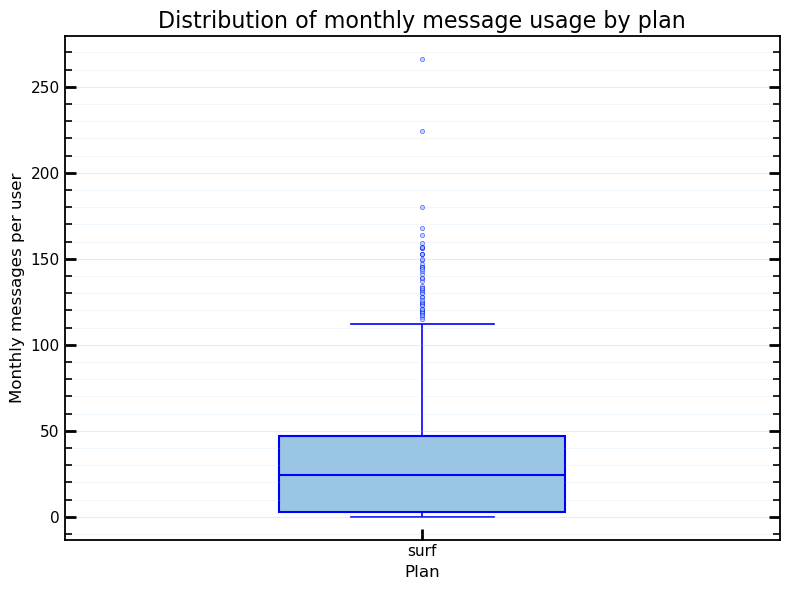

In [84]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.boxplot(
    data=surf_total_mess,
    x='plan',
    y='total_messages_per_user_per_month_by_plan',
    ax=ax,
    width=0.4,
    color='#8EC7F0',
    linewidth=1.5,
    showfliers=True,
    boxprops=dict(edgecolor='blue'),
    whiskerprops=dict(color='blue', linewidth=1.2),
    capprops=dict(color='blue', linewidth=1.2),
    medianprops=dict(color='blue', linewidth=1.5),
    flierprops=dict(
        marker='o',
        markerfacecolor='#8EC7F0',
        markeredgecolor='blue',
        markersize=3,
        alpha=0.6,
        markeredgewidth=0.5
    )
)

ax.set_xlabel('Plan', fontsize=12)
ax.set_ylabel('Monthly messages per user', fontsize=12)
ax.set_title('Distribution of monthly message usage by plan', fontsize=16)

for side in ['top', 'right', 'bottom', 'left']:
    ax.spines[side].set_linewidth(1.3)

ax.tick_params(labelsize=11)

ax.set_axisbelow(False)

ax.yaxis.set_minor_locator(AutoMinorLocator(2))

ax.grid(axis='y', which='major', linewidth=0.8, alpha=0.28, color='#8EC7F0')
ax.grid(axis='y', which='minor', linewidth=0.5, alpha=0.20, color='#8EC7F0')

setup_minor_ticks(
    ax,
    x_minor_divisions=1,
    y_minor_divisions=5,
    major=(8, 2),
    minor=(5, 1.2),
    sides=dict(top=False, right=True, bottom=True, left=True),
    direction_top='in',
    direction_bottom='in',
    direction_left='in',
    direction_right='in'
)

plt.tight_layout()
plt.show()

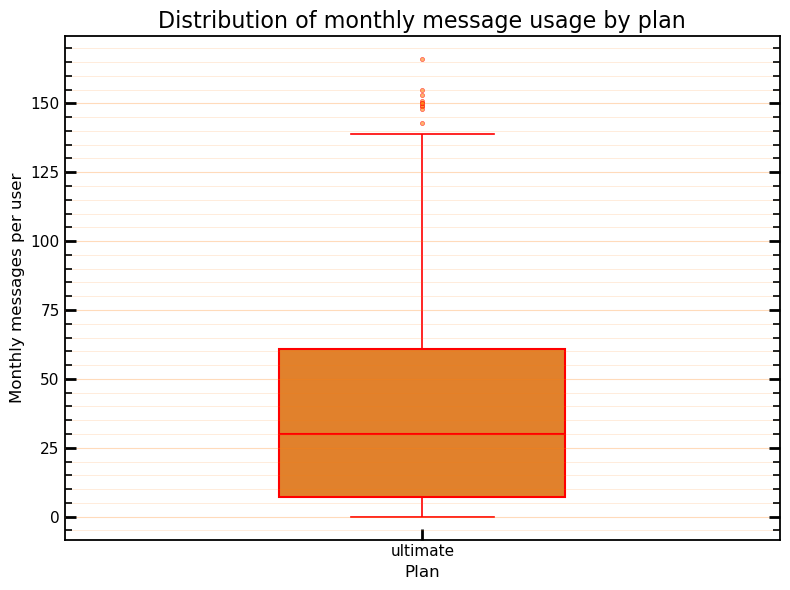

In [85]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.boxplot(
    data=ultimate_total_mess,
    x='plan',
    y='total_messages_per_user_per_month_by_plan',
    ax=ax,
    width=0.4,
    color='#FF7F0E',
    linewidth=1.5,
    showfliers=True,
    boxprops=dict(edgecolor='red'),
    whiskerprops=dict(color='red', linewidth=1.2),
    capprops=dict(color='red', linewidth=1.2),
    medianprops=dict(color='red', linewidth=1.5),
    flierprops=dict(
        marker='o',
        markerfacecolor='#FF7F0E',
        markeredgecolor='red',
        markersize=3,
        alpha=0.6,
        markeredgewidth=0.5
    )
)

ax.set_xlabel('Plan', fontsize=12)
ax.set_ylabel('Monthly messages per user', fontsize=12)
ax.set_title('Distribution of monthly message usage by plan', fontsize=16)

for side in ['top', 'right', 'bottom', 'left']:
    ax.spines[side].set_linewidth(1.3)

ax.tick_params(labelsize=11)

ax.set_axisbelow(False)

ax.yaxis.set_minor_locator(AutoMinorLocator(2))

ax.grid(axis='y', which='major', linewidth=0.8, alpha=0.28, color='#FF7F0E')
ax.grid(axis='y', which='minor', linewidth=0.5, alpha=0.20, color='#FF7F0E')

setup_minor_ticks(
    ax,
    x_minor_divisions=1,
    y_minor_divisions=5,
    major=(8, 2),
    minor=(5, 1.2),
    sides=dict(top=False, right=True, bottom=True, left=True),
    direction_top='in',
    direction_bottom='in',
    direction_left='in',
    direction_right='in'
)

plt.tight_layout()
plt.show()

In [86]:
surf_total_mess['total_messages_per_user_per_month_by_plan'].describe()

count    1573.000000
mean       31.159568
std        33.566717
min         0.000000
25%         3.000000
50%        24.000000
75%        47.000000
max       266.000000
Name: total_messages_per_user_per_month_by_plan, dtype: float64

In [87]:
ultimate_total_mess['total_messages_per_user_per_month_by_plan'].describe()

count    720.000000
mean      37.551389
std       34.767179
min        0.000000
25%        7.000000
50%       30.000000
75%       61.000000
max      166.000000
Name: total_messages_per_user_per_month_by_plan, dtype: float64

Monthly message usage per user was analyzed using histograms, summary statistics, and boxplots. For both plans, the distributions of monthly message usage are right-skewed, as shown by the histograms. The mean monthly usage is 31 messages for the Surf plan and 38 messages for the Ultimate plan, with corresponding variances of 1,127 and 1,209, respectively, indicating substantial variability in both cases. According to the boxplots and quartile values, half of Surf users send between 3 and 47 messages per month, with a median of 24 messages, while half of Ultimate users send between 7 and 61 messages, with a median of 30 messages. A limited number of users in both plans send substantially more messages, with maximum values reaching 266 messages for Surf and 166 messages for Ultimate. These high-usage observations lie above the upper quartile and correspond to the upper tail observed in the histograms.

In [88]:
# Compare the amount of Internet traffic consumed by users by plan.
mean_of_data_used_per_plan = df_usage.groupby(['plan', 'month'])['gigabytes_used'].mean().reset_index(name = 'avg_gb_used_per_month_by_plan')
display(mean_of_data_used_per_plan)

,plan,month,avg_gb_used_per_month_by_plan
0,surf,1,5.000000
1,surf,2,12.222222
2,surf,3,13.565217
3,surf,4,12.220000
4,surf,5,14.116883
5,surf,6,15.484536
6,surf,7,16.876033
7,surf,8,16.882716
8,surf,9,16.690722
9,surf,10,17.409283


In [89]:
surf_gb_avg = mean_of_data_used_per_plan[mean_of_data_used_per_plan['plan'] == 'surf']
ultimate_gb_avg = mean_of_data_used_per_plan[mean_of_data_used_per_plan['plan'] == 'ultimate']

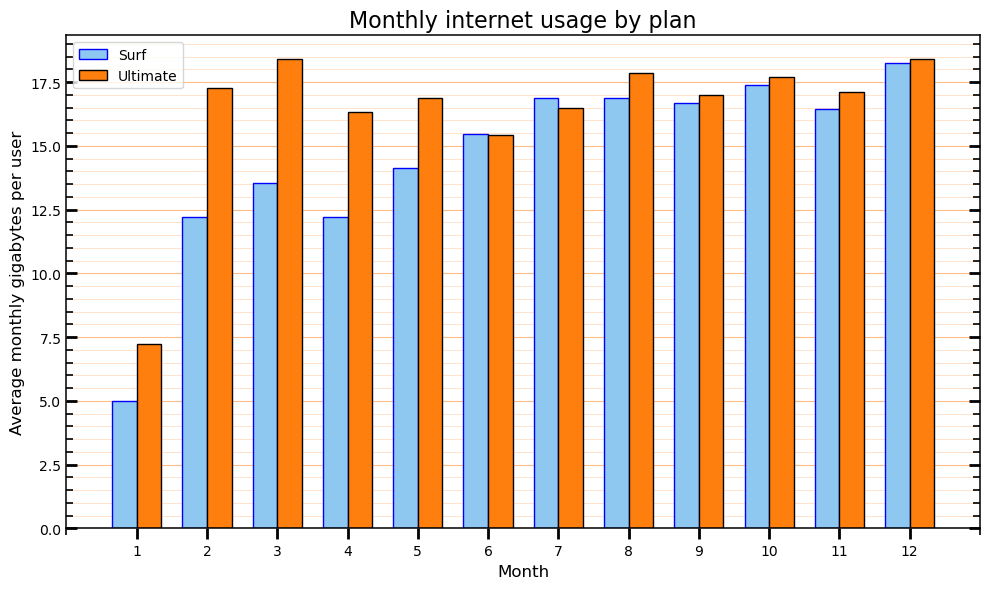

In [90]:
x = np.arange(len(surf_gb_avg['month']))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(
    x - width/2,
    surf_gb_avg['avg_gb_used_per_month_by_plan'].values,
    width=width,
    edgecolor='blue',
    linewidth=1.0,
    color='#8EC7F0',
    alpha=1,
    label='Surf'
)

ax.bar(
    x + width/2,
    ultimate_gb_avg['avg_gb_used_per_month_by_plan'].values,
    width=width,
    edgecolor='black',
    linewidth=1.0,
    color='#FF7F0E',
    alpha=1,
    label='Ultimate'
)

ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Average monthly gigabytes per user', fontsize=12)
ax.set_title('Monthly internet usage by plan', fontsize=16)

ax.set_xticks(x)
ax.set_xticklabels(surf_gb_avg['month'], rotation=0)

for side in ['top', 'right', 'bottom', 'left']:
    ax.spines[side].set_linewidth(1.1)

ax.tick_params(labelsize=10)

ax.set_axisbelow(True)

ax.grid(axis='y', which='major', linewidth=0.8, alpha=0.5, color="#FF7F0E")
ax.grid(axis='y', which='minor', linewidth=0.5, alpha=0.3, color='#FF7F0E')

ax.yaxis.set_minor_locator(AutoMinorLocator(2))

setup_minor_ticks(
    ax,
    x_minor_divisions=1,
    y_minor_divisions=5,
    major=(8, 2),
    minor=(5, 1.2),
    sides=dict(top=False, right=True, bottom=True, left=True),
    direction_top='in',
    direction_bottom='out',
    direction_left='in',
    direction_right='in'
)

ax.set_xlim(-1, len(x))

ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

Monthly average internet usage per user was calculated by plan and by month. For both plans, average data consumption increases over the course of the year. Surf users consume an average of 5.0 GB in the first month and 18.24 GB in the last month, while Ultimate users increase from 7.25 GB to 18.40 GB over the same period. In almost every month, the Ultimate plan shows higher average data usage than the Surf plan, although the difference between plans decreases toward the end of the year.

In [91]:
# The number of monthly gigabytes used by users is compared between plans.
total_of_num_gigabytes_per_plan_per_month = df_usage.groupby(['plan', 'month', 'user_id'])['gigabytes_used'].sum().reset_index(name = 'total_gigabytes_per_user_per_month_by_plan')
display(total_of_num_gigabytes_per_plan_per_month.sort_values(by = 'user_id'))

,plan,month,user_id,total_gigabytes_per_user_per_month_by_plan
2142,ultimate,12,1000,2.0
1255,surf,12,1001,19.0
541,surf,9,1001,14.0
972,surf,11,1001,19.0
735,surf,10,1001,22.0
...,...,...,...,...
160,surf,5,1498,22.0
971,surf,10,1499,20.0
1254,surf,11,1499,17.0
1572,surf,12,1499,22.0


In [92]:
surf_total_gigabytes = total_of_num_gigabytes_per_plan_per_month[total_of_num_gigabytes_per_plan_per_month['plan'] == 'surf']
ultimate_total_gigabytes = total_of_num_gigabytes_per_plan_per_month[total_of_num_gigabytes_per_plan_per_month['plan'] == 'ultimate']


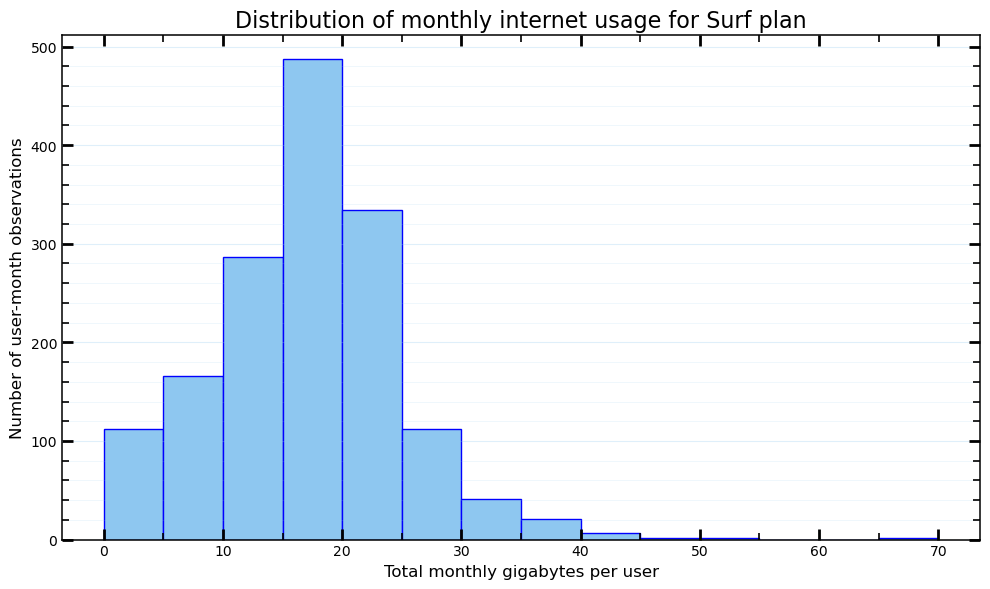

In [93]:
x = surf_total_gigabytes['total_gigabytes_per_user_per_month_by_plan']

bin_width = 5

bins = np.arange(
    x.min(),
    x.max() + bin_width,
    bin_width
)

fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(
    x,
    bins=bins,
    edgecolor='blue',
    linewidth=1.0,
    color='#8EC7F0',
    alpha=1
)

ax.set_xlabel('Total monthly gigabytes per user', fontsize=12)
ax.set_ylabel('Number of user-month observations', fontsize=12)
ax.set_title('Distribution of monthly internet usage for Surf plan', fontsize=16)

for side in ['top', 'right', 'bottom', 'left']:
    ax.spines[side].set_linewidth(1.1)

ax.tick_params(labelsize=10)

# Grid above bars as per your chosen histogram style
ax.set_axisbelow(False)

ax.grid(axis='y', which='major', linewidth=0.8, alpha=0.28, color="#8EC7F0")
ax.grid(axis='y', which='minor', linewidth=0.5, alpha=0.2, color='#8EC7F0')

ax.yaxis.set_minor_locator(AutoMinorLocator(2))

setup_minor_ticks(
    ax,
    x_minor_divisions=2,
    y_minor_divisions=5,
    major=(8, 2),
    minor=(5, 1.2),
    sides=dict(top=True, right=True, bottom=True, left=True),
    direction_top='in',
    direction_bottom='in',
    direction_left='in',
    direction_right='in'
)

plt.tight_layout()
plt.show()

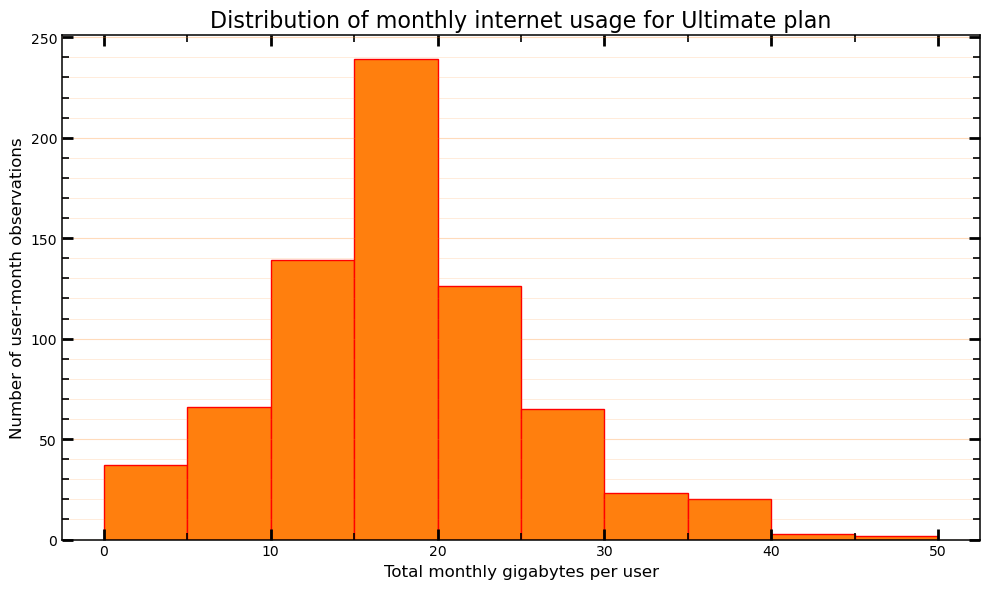

In [94]:
x = ultimate_total_gigabytes['total_gigabytes_per_user_per_month_by_plan']

bin_width = 5

bins = np.arange(
    x.min(),
    x.max() + bin_width,
    bin_width
)

fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(
    x,
    bins=bins,
    edgecolor='red',
    linewidth=1.0,
    color='#FF7F0E',
    alpha=1
)

ax.set_xlabel('Total monthly gigabytes per user', fontsize=12)
ax.set_ylabel('Number of user-month observations', fontsize=12)
ax.set_title('Distribution of monthly internet usage for Ultimate plan', fontsize=16)

for side in ['top', 'right', 'bottom', 'left']:
    ax.spines[side].set_linewidth(1.1)

ax.tick_params(labelsize=10)

ax.set_axisbelow(False)

ax.grid(axis='y', which='major', linewidth=0.8, alpha=0.28, color="#FF7F0E")
ax.grid(axis='y', which='minor', linewidth=0.5, alpha=0.2, color='#FF7F0E')

ax.yaxis.set_minor_locator(AutoMinorLocator(2))

setup_minor_ticks(
    ax,
    x_minor_divisions=2,
    y_minor_divisions=5,
    major=(8, 2),
    minor=(5, 1.2),
    sides=dict(top=True, right=True, bottom=True, left=True),
    direction_top='in',
    direction_bottom='in',
    direction_left='in',
    direction_right='in'
)

plt.tight_layout()
plt.show()

In [95]:
surf_gb_mean = surf_total_gigabytes['total_gigabytes_per_user_per_month_by_plan'].mean()
surf_gb_var = surf_total_gigabytes['total_gigabytes_per_user_per_month_by_plan'].var()
print(surf_gb_mean)
print(surf_gb_var)

16.670692943420217
61.58359983759012


In [96]:
ult_gb_mean = ultimate_total_gigabytes['total_gigabytes_per_user_per_month_by_plan'].mean()
ult_gb_var = ultimate_total_gigabytes['total_gigabytes_per_user_per_month_by_plan'].var()
print(ult_gb_mean)
print(ult_gb_var)

17.306944444444444
58.830549760469786


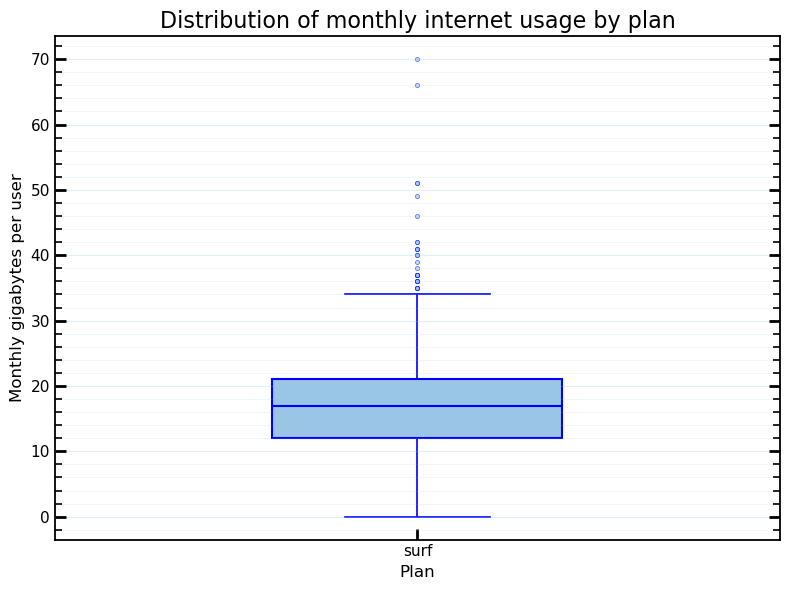

In [97]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.boxplot(
    data=surf_total_gigabytes,
    x='plan',
    y='total_gigabytes_per_user_per_month_by_plan',
    ax=ax,
    width=0.4,
    color='#8EC7F0',
    linewidth=1.5,
    showfliers=True,
    boxprops=dict(edgecolor='blue'),
    whiskerprops=dict(color='blue', linewidth=1.2),
    capprops=dict(color='blue', linewidth=1.2),
    medianprops=dict(color='blue', linewidth=1.5),
    flierprops=dict(
        marker='o',
        markerfacecolor='#8EC7F0',
        markeredgecolor='blue',
        markersize=3,
        alpha=0.6,
        markeredgewidth=0.5
    )
)

ax.set_xlabel('Plan', fontsize=12)
ax.set_ylabel('Monthly gigabytes per user', fontsize=12)
ax.set_title('Distribution of monthly internet usage by plan', fontsize=16)

for side in ['top', 'right', 'bottom', 'left']:
    ax.spines[side].set_linewidth(1.3)

ax.tick_params(labelsize=11)

ax.set_axisbelow(False)

ax.yaxis.set_minor_locator(AutoMinorLocator(2))

ax.grid(axis='y', which='major', linewidth=0.8, alpha=0.28, color='#8EC7F0')
ax.grid(axis='y', which='minor', linewidth=0.5, alpha=0.20, color='#8EC7F0')

setup_minor_ticks(
    ax,
    x_minor_divisions=1,
    y_minor_divisions=5,
    major=(8, 2),
    minor=(5, 1.2),
    sides=dict(top=False, right=True, bottom=True, left=True),
    direction_top='in',
    direction_bottom='in',
    direction_left='in',
    direction_right='in'
)

plt.tight_layout()
plt.show()

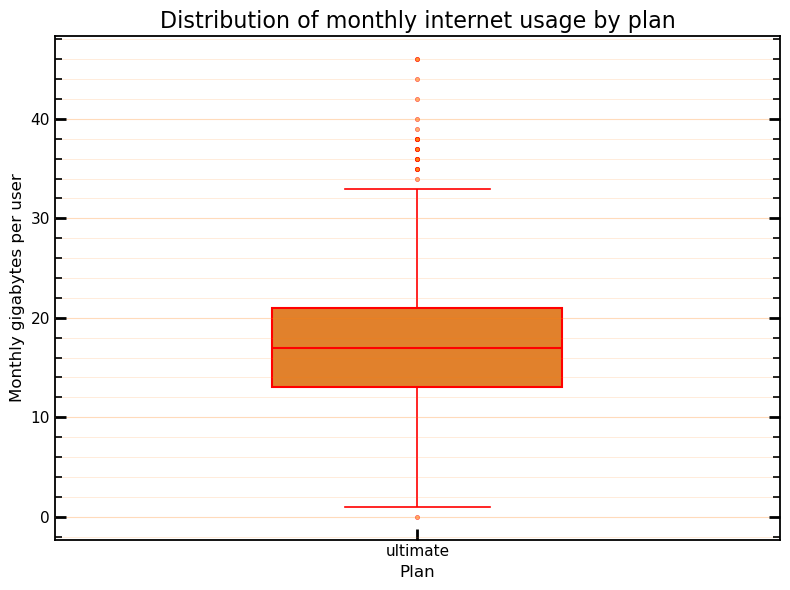

In [98]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.boxplot(
    data=ultimate_total_gigabytes,
    x='plan',
    y='total_gigabytes_per_user_per_month_by_plan',
    ax=ax,
    width=0.4,
    color='#FF7F0E',
    linewidth=1.5,
    showfliers=True,
    boxprops=dict(edgecolor='red'),
    whiskerprops=dict(color='red', linewidth=1.2),
    capprops=dict(color='red', linewidth=1.2),
    medianprops=dict(color='red', linewidth=1.5),
    flierprops=dict(
        marker='o',
        markerfacecolor='#FF7F0E',
        markeredgecolor='red',
        markersize=3,
        alpha=0.6,
        markeredgewidth=0.5
    )
)

ax.set_xlabel('Plan', fontsize=12)
ax.set_ylabel('Monthly gigabytes per user', fontsize=12)
ax.set_title('Distribution of monthly internet usage by plan', fontsize=16)

for side in ['top', 'right', 'bottom', 'left']:
    ax.spines[side].set_linewidth(1.3)

ax.tick_params(labelsize=11)

ax.set_axisbelow(False)

ax.yaxis.set_minor_locator(AutoMinorLocator(2))

ax.grid(axis='y', which='major', linewidth=0.8, alpha=0.28, color='#FF7F0E')
ax.grid(axis='y', which='minor', linewidth=0.5, alpha=0.20, color='#FF7F0E')

setup_minor_ticks(
    ax,
    x_minor_divisions=1,
    y_minor_divisions=5,
    major=(8, 2),
    minor=(5, 1.2),
    sides=dict(top=False, right=True, bottom=True, left=True),
    direction_top='in',
    direction_bottom='in',
    direction_left='in',
    direction_right='in'
)

plt.tight_layout()
plt.show()

In [99]:
surf_total_gigabytes['total_gigabytes_per_user_per_month_by_plan'].describe()

count    1573.000000
mean       16.670693
std         7.847522
min         0.000000
25%        12.000000
50%        17.000000
75%        21.000000
max        70.000000
Name: total_gigabytes_per_user_per_month_by_plan, dtype: float64

In [100]:
ultimate_total_gigabytes['total_gigabytes_per_user_per_month_by_plan'].describe()

count    720.000000
mean      17.306944
std        7.670108
min        0.000000
25%       13.000000
50%       17.000000
75%       21.000000
max       46.000000
Name: total_gigabytes_per_user_per_month_by_plan, dtype: float64

Monthly internet usage per user was analyzed using histograms, summary statistics, and boxplots. For both plans, the distributions of monthly data usage are right-skewed, as shown by the histograms. Most user-month observations are concentrated at lower and intermediate usage levels, while a smaller number of observations extend to higher values, reaching up to 70 GB for the Surf plan and 46 GB for the Ultimate plan. These high-usage observations form the upper tail of the distributions.

The mean monthly data usage equals 16.67 GB for the Surf plan and 17.31 GB for the Ultimate plan. The corresponding standard deviations are 7.85 GB and 7.67 GB, respectively, indicating a comparable level of variability in both plans. According to the quartile values, half of Surf users consume between 12 and 21 GB per month, with a median of 17 GB, while half of Ultimate users consume between 13 and 21 GB, also with a median of 17 GB. The boxplots reflect these results, showing similar medians and interquartile ranges for both plans, along with a limited number of high-usage observations appearing above the upper quartile. These observations are consistent with the right-skewness observed in the histograms and explain why average usage values are influenced by a small number of high-consumption user-months.

In [101]:
display(df_usage)

,user_id,month,num_calls,num_minutes,num_messages,megabytes_used,gigabytes_used,plan,total_charge
0,1000,12,16.0,124.0,11.0,1901.47,2.0,ultimate,70.00
1,1001,8,22.0,182.0,30.0,6919.15,7.0,surf,20.00
2,1001,9,38.0,315.0,44.0,13314.82,14.0,surf,20.00
3,1001,10,47.0,393.0,53.0,22330.49,22.0,surf,90.09
4,1001,11,49.0,426.0,36.0,18504.30,19.0,surf,60.00
...,...,...,...,...,...,...,...,...,...
2288,1498,12,32.0,339.0,0.0,23137.69,23.0,surf,100.00
2289,1499,9,35.0,346.0,0.0,12984.76,13.0,surf,20.00
2290,1499,10,41.0,385.0,0.0,19492.43,20.0,surf,70.00
2291,1499,11,39.0,308.0,0.0,16813.83,17.0,surf,40.00


In [102]:
mean_of_total_charge_per_plan = df_usage.groupby(['plan', 'month'])['total_charge'].mean().reset_index(name = 'avg_total_charge_per_month_by_plan')
display(mean_of_total_charge_per_plan)

,plan,month,avg_total_charge_per_month_by_plan
0,surf,1,20.000000
1,surf,2,34.396667
2,surf,3,45.941304
3,surf,4,40.710600
4,surf,5,47.628182
5,surf,6,49.276289
6,surf,7,62.674050
7,surf,8,63.931173
8,surf,9,58.271495
9,surf,10,65.421224


In [103]:
surf_total_charge_avg = mean_of_total_charge_per_plan[mean_of_total_charge_per_plan['plan'] == 'surf']
ultimate_total_charge_avg = mean_of_total_charge_per_plan[mean_of_total_charge_per_plan['plan'] == 'ultimate']

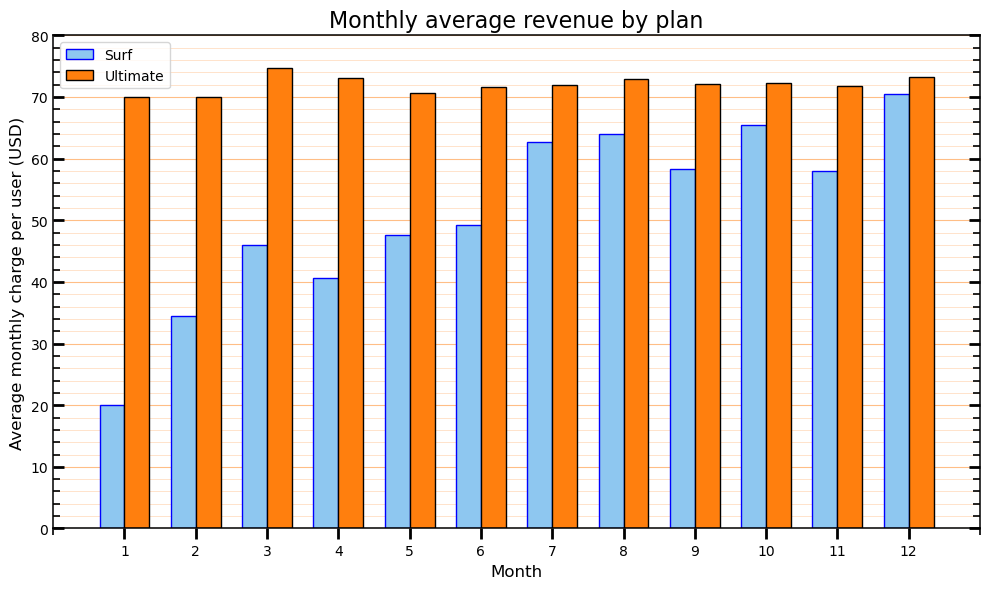

In [104]:
x = np.arange(len(surf_total_charge_avg['month']))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(
    x - width/2,
    surf_total_charge_avg['avg_total_charge_per_month_by_plan'].values,
    width=width,
    edgecolor='blue',
    linewidth=1.0,
    color='#8EC7F0',
    alpha=1,
    label='Surf'
)

ax.bar(
    x + width/2,
    ultimate_total_charge_avg['avg_total_charge_per_month_by_plan'].values,
    width=width,
    edgecolor='black',
    linewidth=1.0,
    color='#FF7F0E',
    alpha=1,
    label='Ultimate'
)

ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Average monthly charge per user (USD)', fontsize=12)
ax.set_title('Monthly average revenue by plan', fontsize=16)

ax.set_xticks(x)
ax.set_xticklabels(surf_total_charge_avg['month'], rotation=0)

for side in ['top', 'right', 'bottom', 'left']:
    ax.spines[side].set_linewidth(1.1)

ax.tick_params(labelsize=10)

ax.set_axisbelow(True)

ax.grid(axis='y', which='major', linewidth=0.8, alpha=0.5, color="#FF7F0E")
ax.grid(axis='y', which='minor', linewidth=0.5, alpha=0.3, color='#FF7F0E')

ax.yaxis.set_minor_locator(AutoMinorLocator(2))

setup_minor_ticks(
    ax,
    x_minor_divisions=1,
    y_minor_divisions=5,
    major=(8, 2),
    minor=(5, 1.2),
    sides=dict(top=False, right=True, bottom=True, left=True),
    direction_top='in',
    direction_bottom='out',
    direction_left='in',
    direction_right='in'
)

ax.set_xlim(-1, len(x))
ax.set_ylim(0, 80)
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

The analysis examines the average total monthly charge per user by plan and by month. For the Surf plan, the average monthly charge increases over the course of the year and shows noticeable variation across months, reflecting the impact of usage-based charges in addition to the base fee. In contrast, the Ultimate plan remains relatively stable throughout the year, with average monthly charges consistently close to the fixed monthly rate of 70 USD.

In [105]:
# The total monthly revenue per user is compared between plans.
total_revenue_per_plan_per_month = df_usage.groupby(['plan', 'month', 'user_id'])['total_charge'].sum().reset_index(name = 'total_revenue_per_user_per_month_by_plan')
display(total_revenue_per_plan_per_month.sort_values(by = 'user_id'))

,plan,month,user_id,total_revenue_per_user_per_month_by_plan
2142,ultimate,12,1000,70.00
1255,surf,12,1001,60.00
541,surf,9,1001,20.00
972,surf,11,1001,60.00
735,surf,10,1001,90.09
...,...,...,...,...
160,surf,5,1498,90.00
971,surf,10,1499,70.00
1254,surf,11,1499,40.00
1572,surf,12,1499,90.00


In [106]:
surf_total_revenue = total_revenue_per_plan_per_month[total_revenue_per_plan_per_month['plan'] == 'surf']
ultimate_total_revenue = total_revenue_per_plan_per_month[total_revenue_per_plan_per_month['plan'] == 'ultimate']


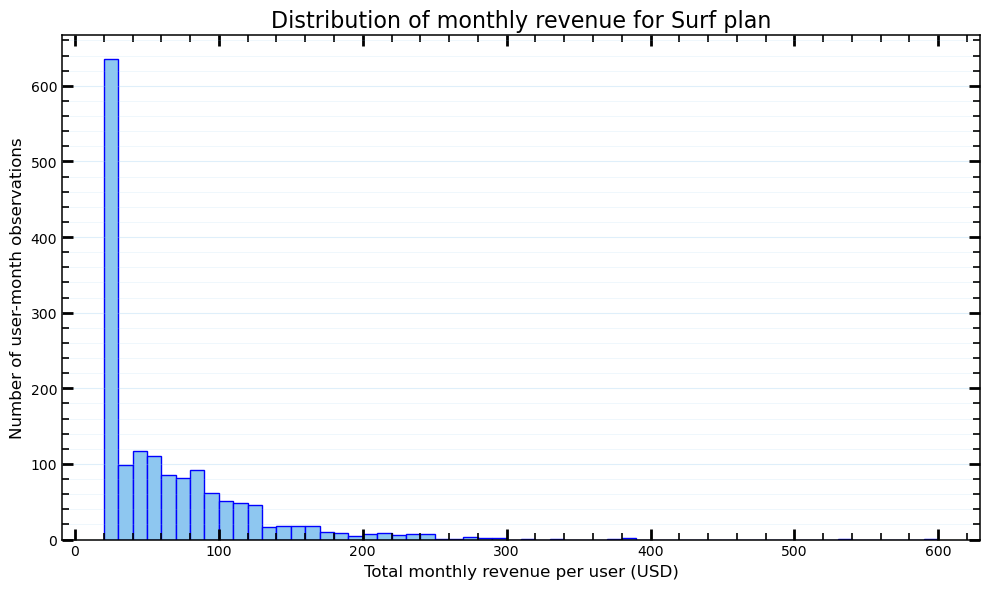

In [107]:
x = surf_total_revenue['total_revenue_per_user_per_month_by_plan']

bin_width = 10

bins = np.arange(
    x.min(),
    x.max() + bin_width,
    bin_width
)

fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(
    x,
    bins=bins,
    edgecolor='blue',
    linewidth=1.0,
    color='#8EC7F0',
    alpha=1
)

ax.set_xlabel('Total monthly revenue per user (USD)', fontsize=12)
ax.set_ylabel('Number of user-month observations', fontsize=12)
ax.set_title('Distribution of monthly revenue for Surf plan', fontsize=16)

for side in ['top', 'right', 'bottom', 'left']:
    ax.spines[side].set_linewidth(1.1)

ax.tick_params(labelsize=10)

ax.set_axisbelow(False)

ax.grid(axis='y', which='major', linewidth=0.8, alpha=0.28, color="#8EC7F0")
ax.grid(axis='y', which='minor', linewidth=0.5, alpha=0.2, color='#8EC7F0')

ax.yaxis.set_minor_locator(AutoMinorLocator(2))

setup_minor_ticks(
    ax,
    x_minor_divisions=5,
    y_minor_divisions=5,
    major=(8, 2),
    minor=(5, 1.2),
    sides=dict(top=True, right=True, bottom=True, left=True),
    direction_top='in',
    direction_bottom='in',
    direction_left='in',
    direction_right='in'
)

plt.tight_layout()
plt.show()

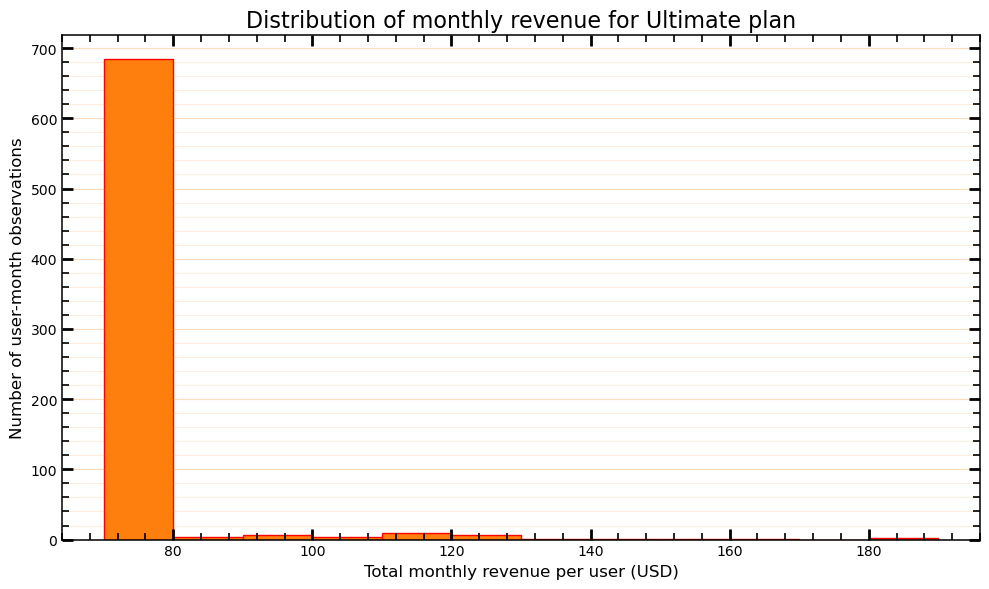

In [108]:
x = ultimate_total_revenue['total_revenue_per_user_per_month_by_plan']

fig, ax = plt.subplots(figsize=(10, 6))

bin_width = 10

bins = np.arange(
    x.min(),
    x.max() + bin_width,
    bin_width
)

ax.hist(
    x,
    bins=bins,
    edgecolor='red',
    linewidth=1.0,
    color='#FF7F0E',
    alpha=1
)

ax.set_xlabel('Total monthly revenue per user (USD)', fontsize=12)
ax.set_ylabel('Number of user-month observations', fontsize=12)
ax.set_title('Distribution of monthly revenue for Ultimate plan', fontsize=16)

for side in ['top', 'right', 'bottom', 'left']:
    ax.spines[side].set_linewidth(1.1)

ax.tick_params(labelsize=10)

ax.set_axisbelow(False)

ax.grid(axis='y', which='major', linewidth=0.8, alpha=0.28, color="#FF7F0E")
ax.grid(axis='y', which='minor', linewidth=0.5, alpha=0.2, color='#FF7F0E')

ax.yaxis.set_minor_locator(AutoMinorLocator(2))

setup_minor_ticks(
    ax,
    x_minor_divisions=5,
    y_minor_divisions=5,
    major=(8, 2),
    minor=(5, 1.2),
    sides=dict(top=True, right=True, bottom=True, left=True),
    direction_top='in',
    direction_bottom='in',
    direction_left='in',
    direction_right='in'
)

plt.tight_layout()
plt.show()

In [109]:
surf_total_charge_mean = surf_total_revenue['total_revenue_per_user_per_month_by_plan'].mean()
surf_total_charge_var = surf_total_revenue['total_revenue_per_user_per_month_by_plan'].var()
print(surf_total_charge_mean)
print(surf_total_charge_var)

60.70640813731723
3067.835152293878


In [110]:
ult_total_charge_mean = ultimate_total_revenue['total_revenue_per_user_per_month_by_plan'].mean()
ult_total_charge_var = ultimate_total_revenue['total_revenue_per_user_per_month_by_plan'].var()
print(ult_total_charge_mean)
print(ult_total_charge_var)

72.31388888888888
129.8484855509195


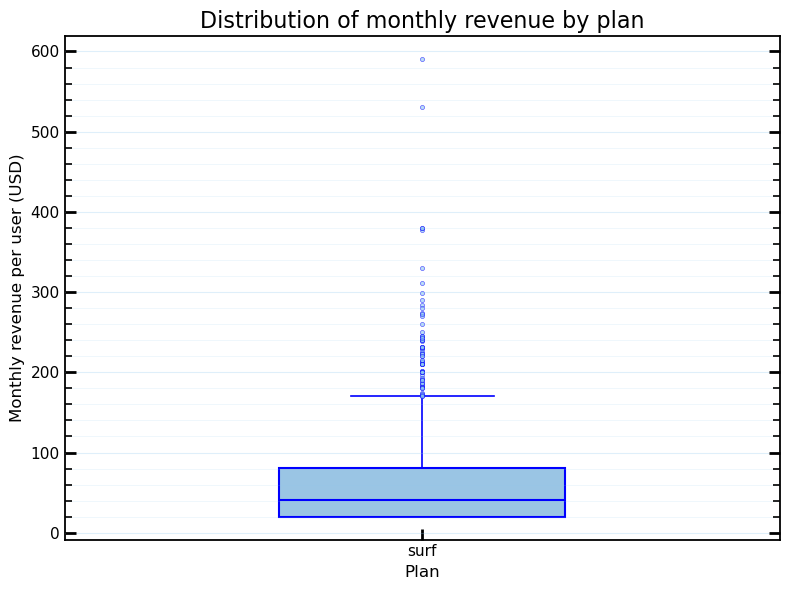

In [111]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.boxplot(
    data=surf_total_revenue,
    x='plan',
    y='total_revenue_per_user_per_month_by_plan',
    ax=ax,
    width=0.4,
    color='#8EC7F0',
    linewidth=1.5,
    showfliers=True,
    boxprops=dict(edgecolor='blue'),
    whiskerprops=dict(color='blue', linewidth=1.2),
    capprops=dict(color='blue', linewidth=1.2),
    medianprops=dict(color='blue', linewidth=1.5),
    flierprops=dict(
        marker='o',
        markerfacecolor='#8EC7F0',
        markeredgecolor='blue',
        markersize=3,
        alpha=0.6,
        markeredgewidth=0.5
    )
)

ax.set_xlabel('Plan', fontsize=12)
ax.set_ylabel('Monthly revenue per user (USD)', fontsize=12)
ax.set_title('Distribution of monthly revenue by plan', fontsize=16)

for side in ['top', 'right', 'bottom', 'left']:
    ax.spines[side].set_linewidth(1.3)

ax.tick_params(labelsize=11)

ax.set_axisbelow(False)

ax.yaxis.set_minor_locator(AutoMinorLocator(2))

ax.grid(axis='y', which='major', linewidth=0.8, alpha=0.28, color='#8EC7F0')
ax.grid(axis='y', which='minor', linewidth=0.5, alpha=0.20, color='#8EC7F0')

setup_minor_ticks(
    ax,
    x_minor_divisions=1,
    y_minor_divisions=5,
    major=(8, 2),
    minor=(5, 1.2),
    sides=dict(top=False, right=True, bottom=True, left=True),
    direction_top='in',
    direction_bottom='in',
    direction_left='in',
    direction_right='in'
)

plt.tight_layout()
plt.show()

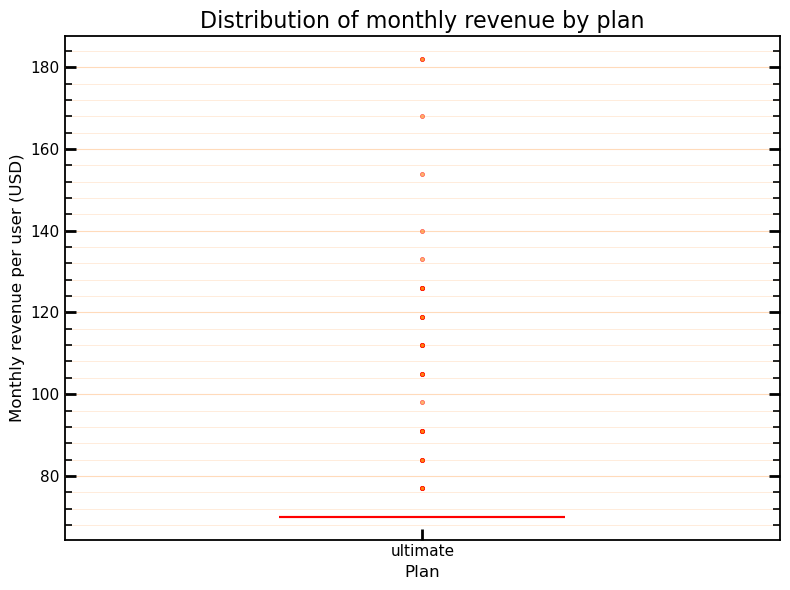

In [112]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.boxplot(
    data=ultimate_total_revenue,
    x='plan',
    y='total_revenue_per_user_per_month_by_plan',
    ax=ax,
    width=0.4,
    color='#FF7F0E',
    linewidth=1.5,
    showfliers=True,
    boxprops=dict(edgecolor='red'),
    whiskerprops=dict(color='red', linewidth=1.2),
    capprops=dict(color='red', linewidth=1.2),
    medianprops=dict(color='red', linewidth=1.5),
    flierprops=dict(
        marker='o',
        markerfacecolor='#FF7F0E',
        markeredgecolor='red',
        markersize=3,
        alpha=0.6,
        markeredgewidth=0.5
    )
)

ax.set_xlabel('Plan', fontsize=12)
ax.set_ylabel('Monthly revenue per user (USD)', fontsize=12)
ax.set_title('Distribution of monthly revenue by plan', fontsize=16)

for side in ['top', 'right', 'bottom', 'left']:
    ax.spines[side].set_linewidth(1.3)

ax.tick_params(labelsize=11)

ax.set_axisbelow(False)

ax.yaxis.set_minor_locator(AutoMinorLocator(2))

ax.grid(axis='y', which='major', linewidth=0.8, alpha=0.28, color='#FF7F0E')
ax.grid(axis='y', which='minor', linewidth=0.5, alpha=0.20, color='#FF7F0E')

setup_minor_ticks(
    ax,
    x_minor_divisions=1,
    y_minor_divisions=5,
    major=(8, 2),
    minor=(5, 1.2),
    sides=dict(top=False, right=True, bottom=True, left=True),
    direction_top='in',
    direction_bottom='in',
    direction_left='in',
    direction_right='in'
)

plt.tight_layout()
plt.show()

In [113]:
surf_total_revenue['total_revenue_per_user_per_month_by_plan'].describe()

count    1573.000000
mean       60.706408
std        55.388042
min        20.000000
25%        20.000000
50%        40.360000
75%        80.360000
max       590.370000
Name: total_revenue_per_user_per_month_by_plan, dtype: float64

In [114]:
ultimate_total_revenue['total_revenue_per_user_per_month_by_plan'].describe()

count    720.000000
mean      72.313889
std       11.395108
min       70.000000
25%       70.000000
50%       70.000000
75%       70.000000
max      182.000000
Name: total_revenue_per_user_per_month_by_plan, dtype: float64

Monthly total revenue per user was analyzed using histograms, summary statistics, and boxplots. For the Surf plan, the distribution of monthly revenue is strongly right-skewed. The majority of user-month observations are concentrated at lower revenue levels, while a limited number of observations extend to very high values, reaching up to approximately 590 USD. These high-revenue observations form a long upper tail in the histogram.

The summary statistics show that the mean monthly revenue for Surf users is 60.71 USD, with a standard deviation of 55.39 USD, indicating substantial variability in monthly charges. The median revenue is 40.36 USD, with half of Surf users paying between 20.00 and 80.36 USD per month. The minimum observed charge equals the base monthly fee of 20 USD, while higher values reflect additional usage-based charges.

In contrast, the Ultimate plan exhibits a markedly different pattern. The distribution of monthly revenue is highly concentrated around the fixed monthly fee. The mean monthly revenue is 72.31 USD, with a standard deviation of 11.40 USD. The median, as well as the first and third quartiles, are all equal to 70 USD, indicating that at least half of Ultimate users pay exactly the base monthly charge. A smaller number of observations exceed this value, reaching up to 182 USD, which appear as isolated points in both the histograms and boxplots.

The boxplots are consistent with these findings. Surf shows a wide interquartile range and numerous high-revenue observations above the upper quartile, reflecting strong dependence on usage-driven charges. Ultimate, by contrast, displays a highly concentrated distribution around its monthly fee, with limited dispersion and relatively few high-revenue observations. Overall, total monthly revenue varies substantially for Surf users due to additional charges, whereas Ultimate users typically incur a nearly constant monthly cost.

## 5. Revenue hypothesis testing

### 5.1 Hypothesis test: comparison of average monthly revenue by plan at the monthly level

H_0 = The average monthly revenue from users of the Surf plan is equal to the average monthly revenue from users of the Ultimate plan.

H_1 = The average monthly revenue from users of the Surf plan is different from the average monthly revenue from users of the Ultimate plan.


In [115]:
surf = df_usage[df_usage['plan'] == 'surf']['total_charge']
ultimate = df_usage[df_usage['plan'] == 'ultimate']['total_charge']

In [116]:
alpha = 0.01

t_stat, p_value = stats.ttest_ind(surf, ultimate, equal_var = False)

if p_value < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')
print(p_value)

We reject the null hypothesis
3.17039054811358e-15


The null hypothesis was rejected at the 0.01 significance level. The p-value 3.17x10^(-15) indicates a statistically significant difference in average monthly revenue between the Surf and Ultimate plans.

### 5.2 Hypothesis test: comparison of average monthly revenue by plan at the user level

Null hypothesis (H_0): The average monthly revenue per user is the same for users on the Surf plan and users on the Ultimate plan.

Alternative hypothesis (H_1): The average monthly revenue per user is different for users on the Surf plan and users on the Ultimate plan.

In [117]:
user_monthly_avg = df_usage.groupby(['user_id', 'plan'])['total_charge'].mean().reset_index(name = 'avg_total_charge')

In [118]:
surf = user_monthly_avg[user_monthly_avg['plan'] == 'surf']['avg_total_charge']
ultimate = user_monthly_avg[user_monthly_avg['plan'] == 'ultimate']['avg_total_charge']

In [119]:
alpha = 0.01

t_stat, p_value = stats.ttest_ind(surf, ultimate, equal_var = False)

if p_value < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')
print(p_value)

We reject the null hypothesis
5.719435130362435e-08


After aggregating charges at the user level, the hypothesis test was repeated. At a significance level of 0.01, the null hypothesis is again rejected. The p-value 5.72x10^(-8) remains well below the significance threshold, indicating a statistically significant difference in average monthly revenue between Surf and Ultimate users.

In [120]:
display(df_megaline_users)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,is_active
0,1000,anamaria,bauer,45,atlanta_sandy_springs_roswell_ga_msa,2018-12-24,ultimate,NaT,True
1,1001,mickey,wilkerson,28,seattle_tacoma_bellevue_wa_msa,2018-08-13,surf,NaT,True
2,1002,carlee,hoffman,36,las_vegas_henderson_paradise_nv_msa,2018-10-21,surf,NaT,True
3,1003,reynaldo,jenkins,52,tulsa_ok_msa,2018-01-28,surf,NaT,True
4,1004,leonila,thompson,40,seattle_tacoma_bellevue_wa_msa,2018-05-23,surf,NaT,True
...,...,...,...,...,...,...,...,...,...
495,1495,fidel,sharpe,67,new_york_newark_jersey_city_ny_nj_pa_msa,2018-09-04,surf,NaT,True
496,1496,ariel,shepherd,49,new_orleans_metairie_la_msa,2018-02-20,surf,NaT,True
497,1497,donte,barrera,49,los_angeles_long_beach_anaheim_ca_msa,2018-12-10,ultimate,NaT,True
498,1498,scot,williamson,51,new_york_newark_jersey_city_ny_nj_pa_msa,2018-02-04,surf,NaT,True


In [121]:
df_usage = df_usage.merge(
    df_megaline_users[['user_id','city']], on = 'user_id', how = 'left'
)


### 5.3 Hypothesis test: Comparison of average monthly revenue between the NY-NJ area and other regions

Null hypothesis (H_0): The average monthly revenue from users in the NY-NJ area is equal to the average monthly revenue from users in other regions.

Alternative hypothesis (H_1): The average monthly revenue from users in the NY-NJ area is different from the average monthly revenue from users in other regions.

In [122]:
ny_nj = df_usage[df_usage['city'].str.contains('ny_nj', case=False, na=False)]['total_charge']
other_regions = df_usage[~df_usage['city'].str.contains('ny_nj', case=False, na=False)]['total_charge']

In [123]:
alpha = 0.01

t_stat, p_value = stats.ttest_ind(ny_nj, other_regions, equal_var = False)

if p_value < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')
print(p_value)

We fail to reject the null hypothesis
0.03352561588530014


At a significance level of 0.01, the null hypothesis is not rejected. The p-value 0.0335 is greater than the significance threshold, so there is insufficient statistical evidence to conclude that average monthly revenue differs between the NY-NJ area and other regions.

### 5.4 Hypothesis test: comparison of average monthly revenue between the NY-NJ area and other regions at the user level

Null hypothesis (H_0): The average monthly revenue per user in the NY-NJ area is equal to the average monthly revenue per user in other regions.

Alternative hypothesis (H_1): The average monthly revenue per user in the NY-NJ area is different from the average monthly revenue per user in other regions.

In [124]:
df_usage['region_group'] = df_usage['city'].str.contains(
    'ny_nj',
    case=False,
    na=False
).map({True: 'ny_nj', False: 'other'})

In [125]:
user_monthly_avg_per_region = (
    df_usage
    .groupby(['user_id', 'region_group'])['total_charge']
    .mean()
    .reset_index(name='avg_total_charge_per_region')
)

In [126]:
ny_nj_user_level = user_monthly_avg_per_region[user_monthly_avg_per_region['region_group'] == 'ny_nj']['avg_total_charge_per_region']
other = user_monthly_avg_per_region[user_monthly_avg_per_region['region_group'] == 'other']['avg_total_charge_per_region']

In [127]:
alpha = 0.01

t_stat, p_value = stats.ttest_ind(ny_nj_user_level, other, equal_var = False)

if p_value < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')
print(p_value)

We fail to reject the null hypothesis
0.44104821081481743


Using a 0.01 significance level, the test does not provide enough evidence to detect a difference in average monthly revenue between users in the NY-NJ area and those in other regions. The observed p-value 0.441 exceeds the chosen threshold, so the null hypothesis cannot be rejected.

## 6. Revenue comparison

In [128]:
surf_total_earnings = df_usage.groupby('plan')['total_charge'].sum()
print(surf_total_earnings)

plan
surf        95491.18
ultimate    52066.00
Name: total_charge, dtype: float64


## 7. Overall conclusion

This analysis examined customer behavior and revenue generation for the Surf and Ultimate prepaid plans using data from 500 users during 2018. Call behavior is similar across plans: the average number of monthly call minutes show comparable patterns over time, with no meaningful differences between Surf and Ultimate. Message usage and internet usage are higher on average for the Ultimate plan, while variability over time is similar across plans.

Despite these differences in usage, the most relevant distinction appears in monthly charges. Ultimate users pay a higher and more stable monthly amount, while Surf users show substantial variability driven by usage-based charges. Hypothesis tests conducted at both the monthly and user aggregation levels reject the null hypothesis of equal average monthly revenue between plans at the 0.01 significance level, providing strong evidence that Ultimate users pay more on average per month.

However, the objective of the analysis is to determine which plan generates more total revenue. Although Ultimate has a higher average monthly revenue per user, it has fewer users. Over the full year, total revenue from the Surf plan amounts to 95,491.18 USD, compared to 52,066.00 USD for the Ultimate plan. Without considering operational costs or other external factors, Surf generates more total revenue due to its larger user base and higher cumulative usage-based charges.

Therefore, based on the available data, the Surf plan generates more revenue overall and should be prioritized when allocating the adverstising budget.